In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor as rfg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PredictXANES import xanes_derivatives

In [3]:
def noise_smooth(df, Noise, size=None):
    '''
    noise_smooth will add noise and then smooth the noise using a savgol filter
    Neural network is trained on averaged spectra only. The spectra are split into a training set and 
    testing set with a ratio of 4:1. The predicted features are the coordination number, 
    number of Cu atoms, and number of Te atoms.
    '''
    if size == None:
        pass
    
    else:
        df = df.sample(n=10000)
        
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    
    xs = np.linspace(8970, 9050, 1000)
    energies = np.linspace(8970, 9050, 100)
    noise = np.random.normal(0, 0.020, 1000)

    if Noise == 0:
        X_smooth = X
        y = df[['CN', 'Num Cu', 'Num Te']]
        X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=size, random_state=519)

    else:
        X_smooth = np.empty([10000,1000])
        for i in range(X.shape[0]):
            s1 = UnivariateSpline(energies, X.loc[i], s=0)
            y1 = s1(xs) # generate a line with 1000 data, the amount of data depend on the xs num the third parameter
            y2 = y1 + noise
            # smooth twice
            ysmooth = savgol_filter(y2, 101, 2)
            ysmooth_twiced = savgol_filter(ysmooth, 51, 3)
            #ysmooth_twiced_array = np.array([])
            X_smooth[i] = ysmooth_twiced
    
        y = df[['CN', 'Num Cu', 'Num Te']]
        X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=0.20, random_state=519)
    
    return X_train, X_test, y_train, y_test, X_smooth, y

def derivatives(X_smooth, x_axis):
    '''
    derivatives returns the first, second, and combined first and second derivitive dataframes after smoothing
    '''
    dmu1 = np.zeros([np.shape(X_smooth)[0], np.shape(X_smooth)[1]-1])
    dmu2 = np.zeros([np.shape(X_smooth)[0], np.shape(X_smooth)[1]-2])
    dx = x_axis[1] - x_axis[0]
    for i in range(np.shape(X_smooth)[0]):
        for j in range(np.shape(dmu1)[1]):
            dmu1[i, j] = (X_smooth.iloc[i, j+1] - X_smooth.iloc[i, j]) / dx

    dmu1_smoothed = savgol_filter(dmu1, 51, 2)

    for i in range(np.shape(X_smooth)[0]):
        for j in range(np.shape(dmu2)[1]):
            dmu2[i, j] = (dmu1_smoothed[i, j+1] - dmu1_smoothed[i, j]) / dx
    
    df1 = pd.DataFrame(dmu1)
    df2 = pd.DataFrame(dmu2)
    df3 = pd.concat([df1, df2], axis=1)

    return df1, df2, df3
    
    

def train_rf(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    rf = rfg(n_estimators=2500, random_state = 28)
    rf = rf.fit(X_train, y_train)
    
    return rf


def analyse_layer(X_train, X_test, y_train, y_test, rf):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, test_mse_Cu, test_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_master_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_master_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_master_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_master_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_master_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_master_list.append(score_Te)

def plot_layer(y_test, y_test_pred):
    '''
    plot_layer is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    rf = train_rf(X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, rf) #series from dataframe after generating and smoothing noise
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)
#     plot_layer(y_test, y_test_pred)

def MLP_per_noise_spectra(df, Noise_STD, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise
    '''
    for entry in Noise_STD:
        X_train, X_test, y_train, y_test, X_noise, y = noise_smooth(df, entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)
    print(rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

def MLP_per_noise_1(df, Noise_STD, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1):
    for entry in Noise_STD:
        _, _, _, _, X_smooth, y = noise_smooth(df, entry)
        df1, df2, df3, = derivatives(X_smooth)
        X_train, X_test, y_train, y_test = train_test_split(df1, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)
    print(rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

def MLP_per_noise_2(df, Noise_STD, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2):
    for entry in Noise_STD:
        _, _, _, _, X_smooth, y = noise_smooth(df, entry)
        df1, df2, df3, = derivatives(X_smooth)
        X_train, X_test, y_train, y_test = train_test_split(df2, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    print(rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    
    
def MLP_per_noise_1_2(df, Noise_STD, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2):
    for entry in Noise_STD:
        _, _, _, _, X_smooth, y = noise_smooth(df, entry)
        df1, df2, df3, = derivatives(X_smooth)
        X_train, X_test, y_train, y_test = train_test_split(df3, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)
    print(rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)

def MLP_per_size_spectra(df, size, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise
    '''
    for entry in size:
        X_train, X_test, y_train, y_test, X_noise, y = noise_smooth(df, Noise=0, size=entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)
    print(rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

def MLP_per_size_1(df, size, x_axis, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1):

    for entry in size:
        _, _, _, _, X_smooth, y = noise_smooth(df, Noise=0, size=entry)
        df1, df2, df3, = derivatives(X_smooth, x_axis)
        X_train, X_test, y_train, y_test = train_test_split(df1, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)
    print(rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

def MLP_per_size_2(df, size, x_axis, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2):
    for entry in size:
        _, _, _, _, X_smooth, y = noise_smooth(df, Noise=0, size=entry)
        df1, df2, df3, = derivatives(X_smooth, x_axis)
        X_train, X_test, y_train, y_test = train_test_split(df2, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    print(rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    
    
def MLP_per_size_1_2(df, size, x_axis, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2):
    for entry in size:
        _, _, _, _, X_smooth, y = noise_smooth(df, Noise=0, size=entry)
        df1, df2, df3, = derivatives(X_smooth, x_axis)
        X_train, X_test, y_train, y_test = train_test_split(df3, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)
    print(rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)

Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [4]:
df = pd.read_csv('mu_cn10000.csv')

## Spectra Only:

Create lists for plotting noise vs R2 an RMSE

In [6]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
rmse_CN_master_list = []
score_CN_master_list = []
rmse_Cu_master_list = []
score_Cu_master_list = []
rmse_Te_master_list = []
score_Te_master_list = []

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached an

           0
0   0.098752
1   0.097992
2   0.035320
3   0.100339
4   0.103027
5   0.038500
6   0.099376
7   0.022346
8   0.036473
9   0.042880
10  0.037450
11  0.038739
12  0.014527
13  0.031731
14  0.019378
15  0.031486
16  0.011757
17  0.042139
18  0.011201
19  0.012143
20  0.040405
21  0.010913
22  0.016691
23  0.043381
24  0.011137
25  0.037005
26  0.035971
27  0.013256
28  0.037368
29  0.010403
30  0.012371
31  0.013692
32  0.010788
33  0.016949
34  0.011707
35  0.012242
36  0.014968
37  0.036387
38  0.010860
39  0.011299
40  0.042580
41  0.011288
42  0.035141
43  0.016352
44  0.012258
45  0.014370
46  0.015477
47  0.017480
48  0.033233
49  0.010267
50  0.035902
51  0.015462
52  0.012378
53  0.029368
54  0.015196
55  0.035187
56  0.013112
57  0.012717
58  0.043777
59  0.014179
60  0.013502
61  0.033639
62  0.040836
63  0.028402
64  0.010975
65  0.013642
66  0.013544
67  0.010158
68  0.013608
69  0.020842
70  0.018210
71  0.037642
72  0.011289
73  0.020108
74  0.014513
75  0.015967

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached an

           0
0   0.098788
1   0.098008
2   0.032582
3   0.100374
4   0.103106
5   0.033998
6   0.099445
7   0.024245
8   0.037035
9   0.039348
10  0.037755
11  0.039161
12  0.018699
13  0.032690
14  0.022266
15  0.034284
16  0.026919
17  0.042471
18  0.036568
19  0.016734
20  0.040714
21  0.017419
22  0.020054
23  0.043690
24  0.018741
25  0.021288
26  0.019867
27  0.019094
28  0.033489
29  0.017811
30  0.017582
31  0.016154
32  0.020724
33  0.019833
34  0.020613
35  0.018666
36  0.019046
37  0.037697
38  0.017231
39  0.015458
40  0.042572
41  0.019448
42  0.035479
43  0.018740
44  0.031633
45  0.023138
46  0.015595
47  0.023035
48  0.021685
49  0.018999
50  0.021125
51  0.020712
52  0.035787
53  0.018528
54  0.030191
55  0.035832
56  0.033738
57  0.020129
58  0.044088
59  0.020145
60  0.020127
61  0.034336
62  0.041406
63  0.032190
64  0.018919
65  0.017023
66  0.018224
67  0.026006
68  0.038434
69  0.026066
70  0.020881
71  0.038108
72  0.017250
73  0.023440
74  0.027473
75  0.029476

0.04749059864818781
training mse =  [0.1280524119902518, 0.14792319407686544, 0.013637578793598643]
testing mse = [0.13643830364813941, 0.14792319407686544, 0.013637578793598643]
training R2 = [0.32065512083937886, 0.5551788933230347, 0.7341934097652142]
testing R2 = [0.33069103818975654, 0.5612517854808172, 0.7296915390869108]
           0
0   0.099549
1   0.099228
2   0.050991
3   0.101887
4   0.105283
5   0.052002
6   0.051286
7   0.053234
8   0.050487
9   0.053134
10  0.051626
11  0.052251
12  0.052889
13  0.052611
14  0.051708
15  0.050289
16  0.051399
17  0.051898
18  0.051791
19  0.051941
20  0.052176
21  0.049739
22  0.051498
23  0.052689
24  0.050527
25  0.052204
26  0.049900
27  0.051388
28  0.051033
29  0.050161
30  0.050551
31  0.053030
32  0.050776
33  0.050887
34  0.052057
35  0.050445
36  0.051424
37  0.052432
38  0.052258
39  0.051924
40  0.051768
41  0.052415
42  0.054514
43  0.053528
44  0.051855
45  0.052981
46  0.050452
47  0.052801
48  0.050485
49  0.050739
50  0.0

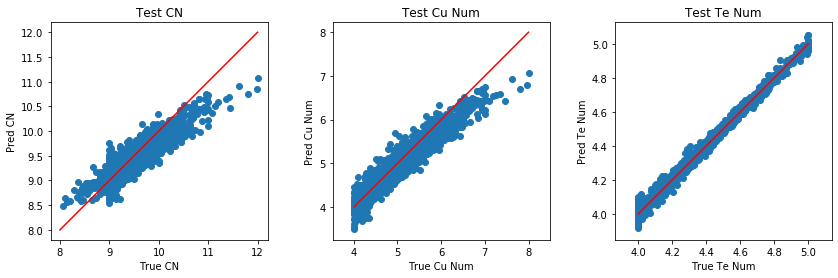

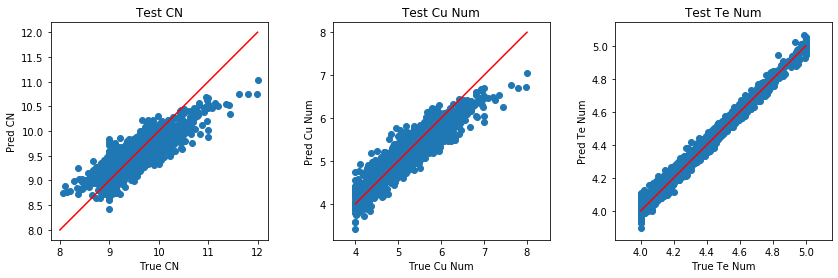

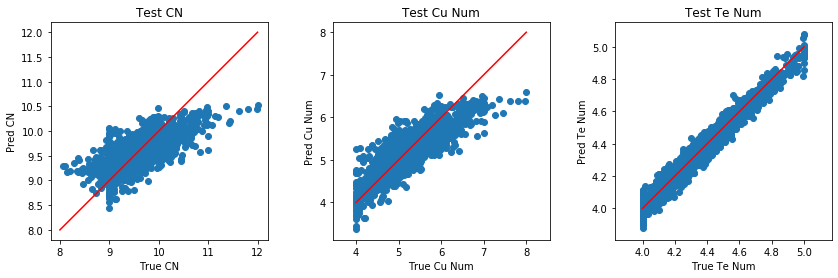

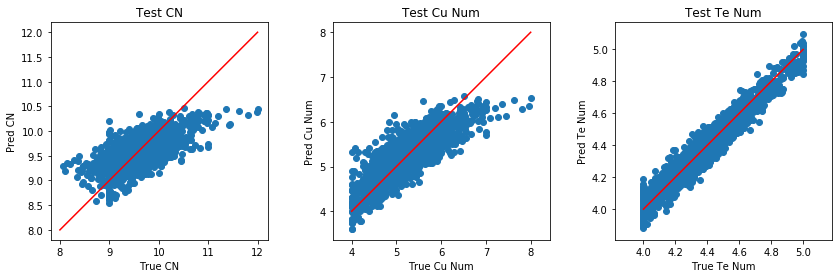

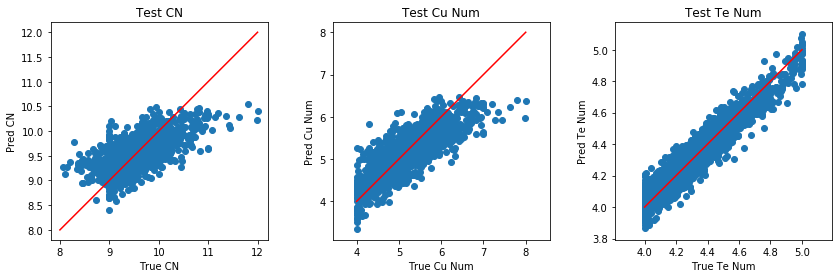

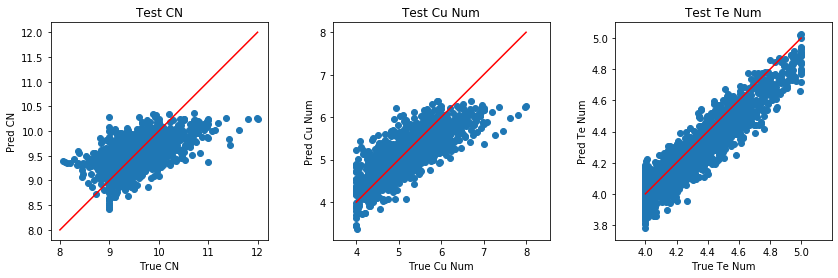

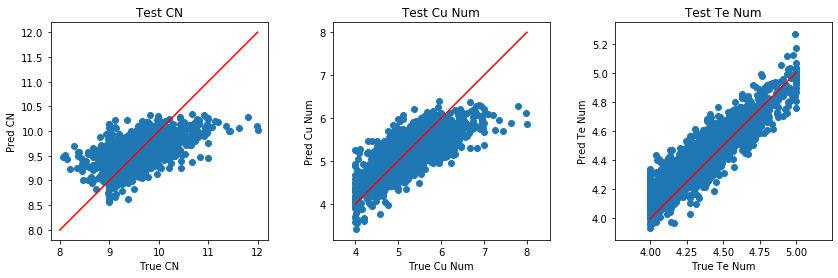

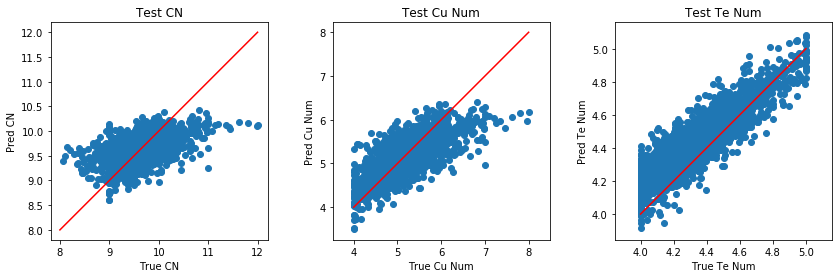

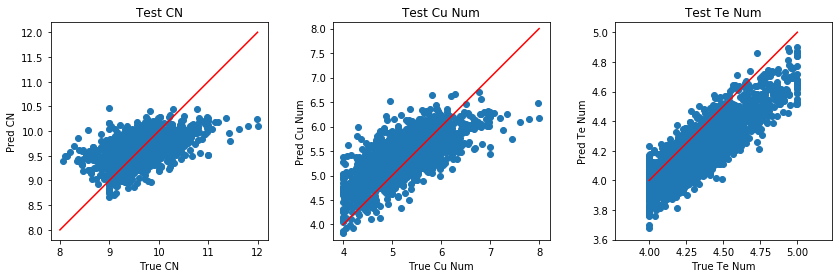

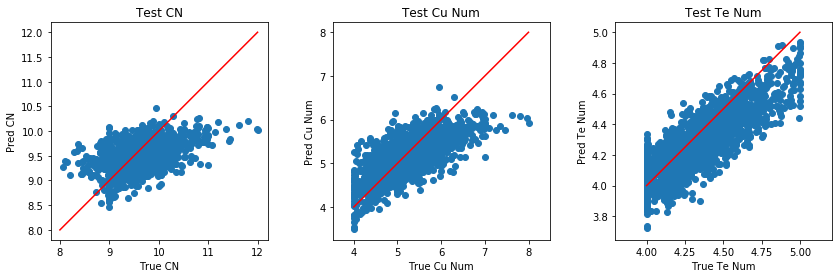

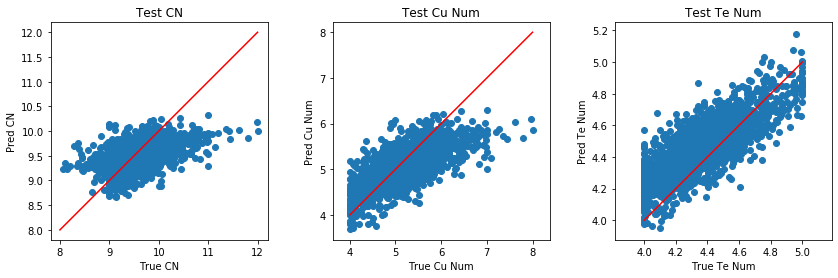

In [6]:
MLP_per_noise_spectra(df, Noise_STD, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

# Repeated for training with first derivative.

In [9]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
rmse_CN_master_list_1 = []
score_CN_master_list_1 = []
rmse_Cu_master_list_1 = []
score_Cu_master_list_1 = []
rmse_Te_master_list_1 = []
score_Te_master_list_1 = []

           0
0   0.083335
1   0.014846
2   0.012970
3   0.013032
4   0.012048
5   0.012810
6   0.010658
7   0.009619
8   0.008443
9   0.011705
10  0.008993
11  0.009256
12  0.009985
13  0.005946
14  0.007025
15  0.006510
16  0.006809
17  0.006744
18  0.006359
19  0.006582
20  0.006672
21  0.005552
22  0.005482
23  0.005063
24  0.005399
25  0.004572
26  0.006057
27  0.004980
28  0.005235
29  0.006319
30  0.005658
31  0.005250
32  0.005723
33  0.005504
34  0.004890
35  0.005549
36  0.005046
37  0.006013
38  0.005135
39  0.005353
40  0.004915
41  0.004476
42  0.004875
43  0.005059
44  0.005229
45  0.005213
46  0.004814
47  0.005079
48  0.004773
49  0.004355
50  0.004466
51  0.005820
52  0.004247
53  0.004569
54  0.005044
55  0.004284
56  0.004333
57  0.004675
58  0.005242
59  0.004428
60  0.005099
61  0.004631
62  0.004263
63  0.004193
64  0.005246
65  0.004837
66  0.004211
67  0.004553
68  0.004277
69  0.004102
70  0.004273
71  0.004633
72  0.004283
73  0.004370
74  0.004370
75  0.004547

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.043909
1   0.035406
2   0.035276
3   0.033382
4   0.034104
5   0.034258
6   0.034163
7   0.033483
8   0.033620
9   0.034256
10  0.033984
11  0.033408
12  0.033616
13  0.032850
14  0.032588
15  0.033264
16  0.033586
17  0.032341
18  0.032673
19  0.033128
20  0.032458
21  0.033668
22  0.032585
23  0.032388
24  0.033017
25  0.032230
26  0.032786
27  0.033130
28  0.032467
29  0.032226
30  0.032330
31  0.032669
32  0.033246
33  0.032170
34  0.031800
35  0.032097
36  0.032595
37  0.032248
38  0.031845
39  0.033274
40  0.032539
41  0.032396
42  0.032278
43  0.031930
44  0.032202
45  0.033269
46  0.031546
47  0.032596
48  0.032732
49  0.032139
50  0.032969
51  0.032184
52  0.032119
53  0.031884
54  0.032179
55  0.032709
56  0.032542
57  0.032114
58  0.031833
59  0.033262
60  0.033025
61  0.032180
62  0.032106
63  0.031963
64  0.032363
65  0.031679
66  0.032503
67  0.031815
68  0.032783
69  0.031844
70  0.031939
71  0.032203
72  0.031744
73  0.032027
74  0.031811
75  0.031513

0.050354303429748115
training mse =  [0.12937348629619944, 0.15653580595471042, 0.014633549564182237]
testing mse = [0.13615290272872402, 0.15653580595471042, 0.014633549564182237]
training R2 = [0.31781087530695473, 0.529406278542671, 0.7140335088242402]
testing R2 = [0.31010516382767295, 0.5219623312265862, 0.7109850405433942]
           0
0   0.074394
1   0.056999
2   0.056178
3   0.055382
4   0.056418
5   0.055259
6   0.055521
7   0.055811
8   0.055594
9   0.055654
10  0.055242
11  0.055333
12  0.055068
13  0.055261
14  0.055749
15  0.055475
16  0.055376
17  0.056517
18  0.055587
19  0.055547
20  0.055653
21  0.055988
22  0.055623
23  0.055724
24  0.055696
25  0.054992
26  0.055027
27  0.055598
28  0.055532
29  0.055569
30  0.055448
31  0.055383
32  0.055568
33  0.055399
34  0.055147
35  0.055757
36  0.055602
37  0.055214
38  0.055832
39  0.055144
40  0.054829
41  0.055333
42  0.055371
43  0.055373
44  0.055488
45  0.055089
46  0.055704
47  0.055558
48  0.055065
49  0.055274
50  0.

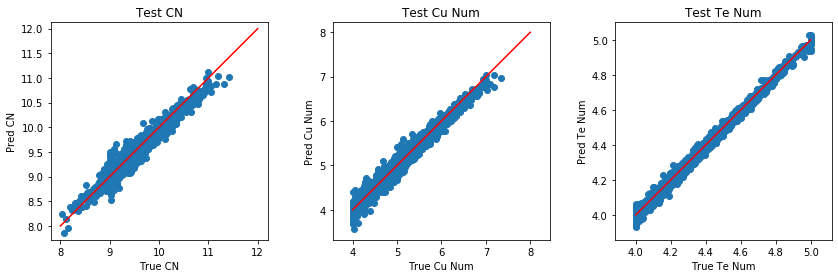

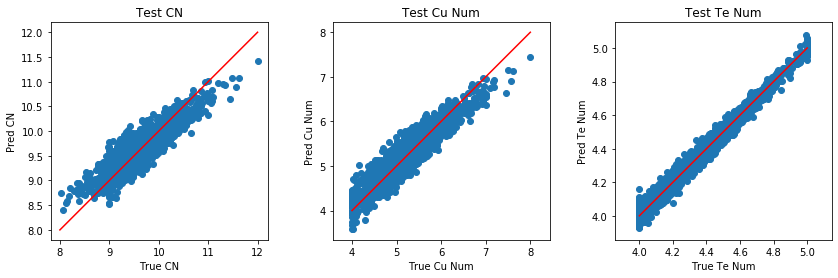

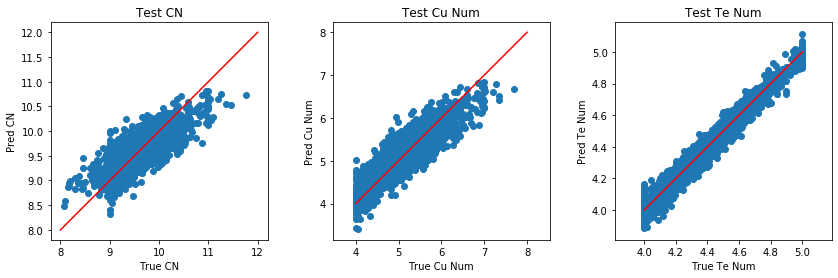

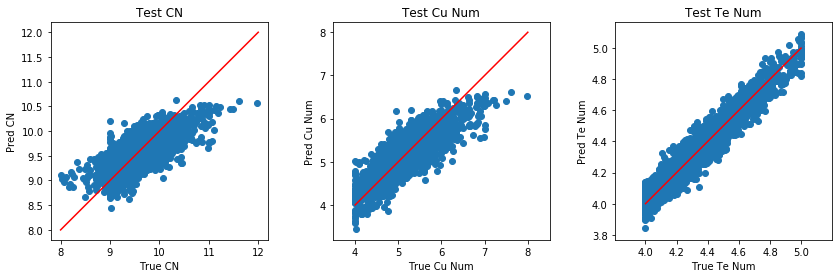

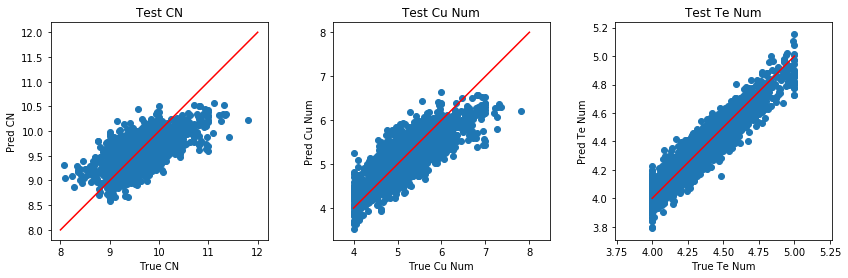

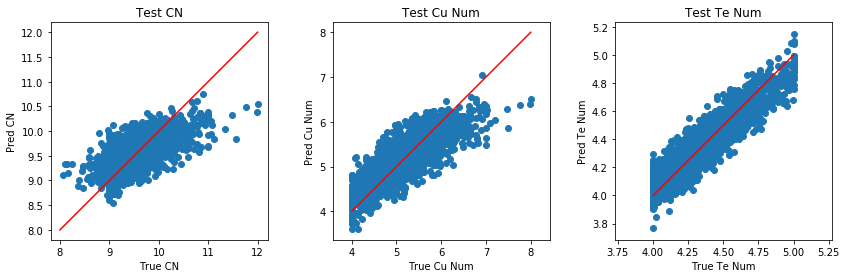

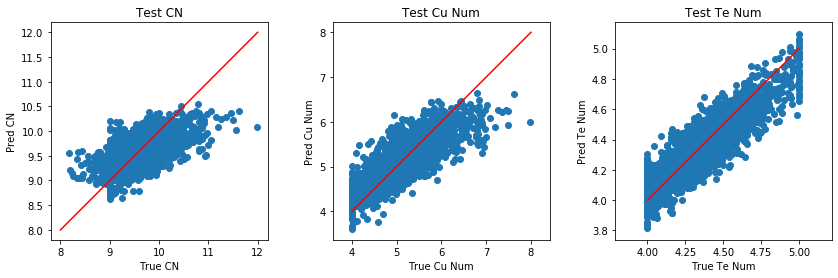

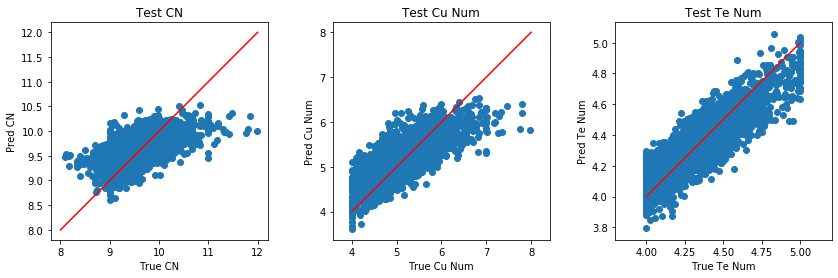

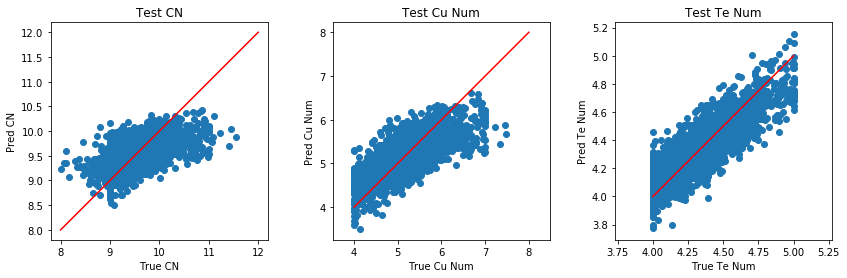

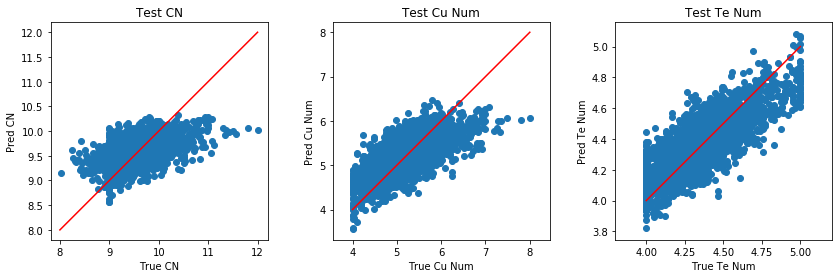

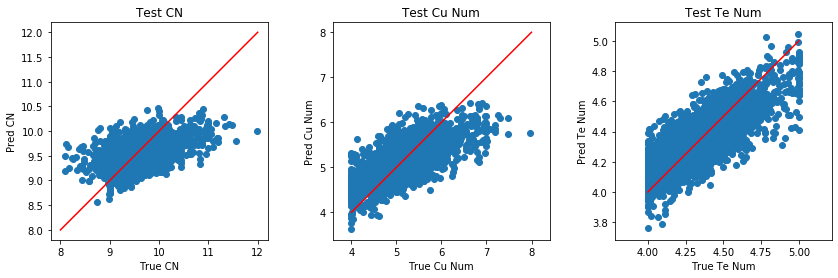

In [10]:
MLP_per_noise_1(df, Noise_STD, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

# Repeated for training with both the first and second derivative.

In [14]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
rmse_CN_master_list_1_2 = []
score_CN_master_list_1_2 = []
rmse_Cu_master_list_1_2 = []
score_Cu_master_list_1_2 = []
rmse_Te_master_list_1_2 = []
score_Te_master_list_1_2 = []

           0
0   0.016815
1   0.011441
2   0.010922
3   0.009750
4   0.008232
5   0.010348
6   0.009066
7   0.006247
8   0.006304
9   0.009023
10  0.006198
11  0.006913
12  0.006082
13  0.005375
14  0.005684
15  0.005598
16  0.005748
17  0.005333
18  0.007454
19  0.006139
20  0.006656
21  0.005328
22  0.007465
23  0.006268
24  0.005328
25  0.006682
26  0.005162
27  0.004698
28  0.005308
29  0.005112
30  0.005295
31  0.005317
32  0.005396
33  0.005269
34  0.005818
35  0.004534
36  0.005298
37  0.005695
38  0.005012
39  0.004756
40  0.005295
41  0.005334
42  0.005012
43  0.004831
44  0.004581
45  0.004880
46  0.005169
47  0.005020
48  0.006140
49  0.004499
50  0.004636
51  0.004961
52  0.004486
53  0.005265
54  0.005873
55  0.005281
56  0.004960
57  0.004917
58  0.005658
59  0.006012
60  0.004676
61  0.005200
62  0.004794
63  0.005046
64  0.004525
65  0.004985
66  0.004403
67  0.004845
68  0.004812
69  0.004901
70  0.005052
71  0.004933
72  0.004432
73  0.005011
74  0.004663
75  0.004920

0.04179505908054069
training mse =  [0.1153430152439798, 0.12728011821946553, 0.00835754754465535]
testing mse = [0.12220520043693045, 0.12728011821946553, 0.00835754754465535]
training R2 = [0.38717880504470936, 0.6168002882092222, 0.8376871021435985]
testing R2 = [0.39389626908506725, 0.6138882950537404, 0.8278108399044096]
           0
0   0.057937
1   0.046605
2   0.046130
3   0.046394
4   0.046297
5   0.045737
6   0.045982
7   0.046025
8   0.046551
9   0.045429
10  0.045975
11  0.045718
12  0.045812
13  0.045887
14  0.046355
15  0.045374
16  0.046313
17  0.046426
18  0.046136
19  0.046070
20  0.046234
21  0.046051
22  0.046192
23  0.046692
24  0.045627
25  0.046377
26  0.045618
27  0.046471
28  0.046034
29  0.045778
30  0.046331
31  0.046051
32  0.045694
33  0.045702
34  0.045433
35  0.046357
36  0.045845
37  0.046271
38  0.045398
39  0.045666
40  0.046515
41  0.046014
42  0.045572
43  0.046162
44  0.045754
45  0.045765
46  0.045872
47  0.046493
48  0.046591
49  0.046193
50  0.046

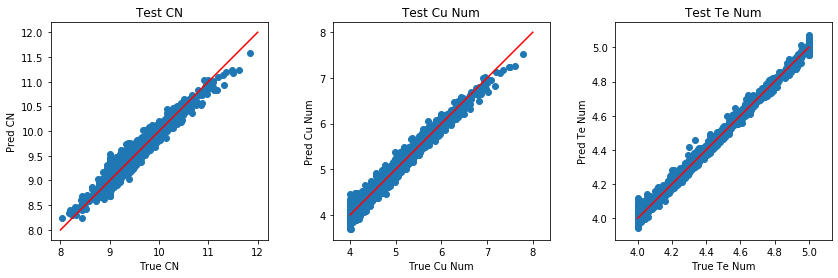

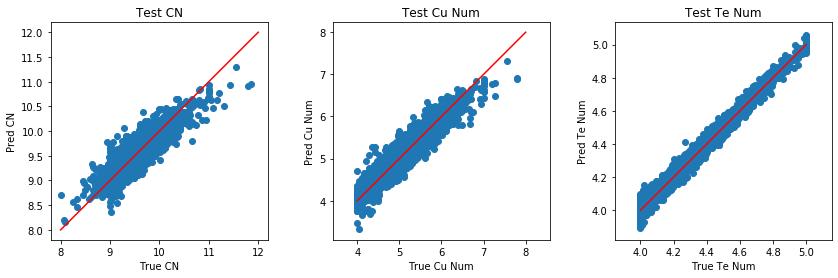

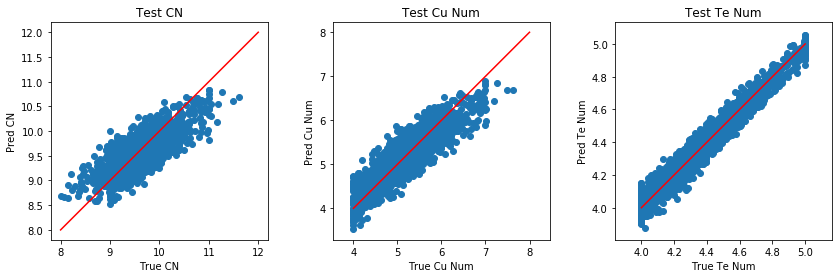

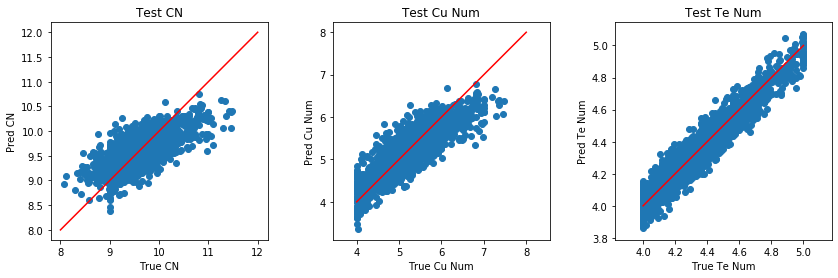

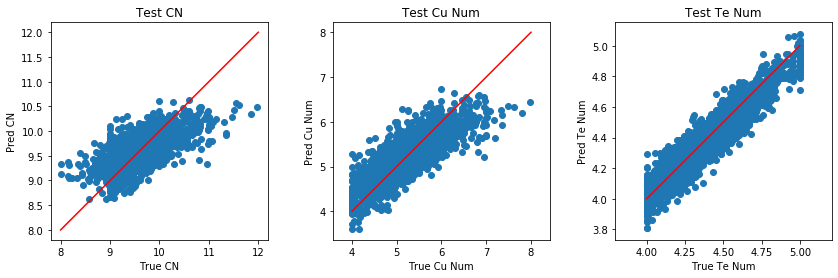

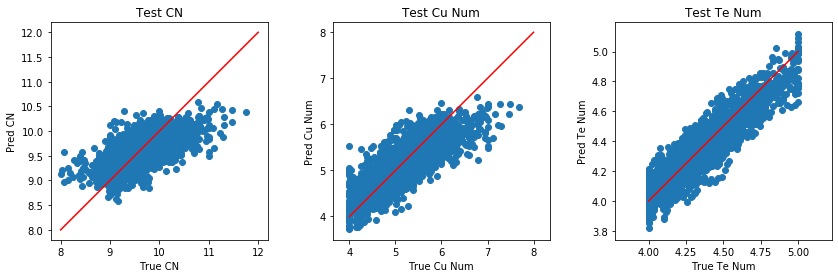

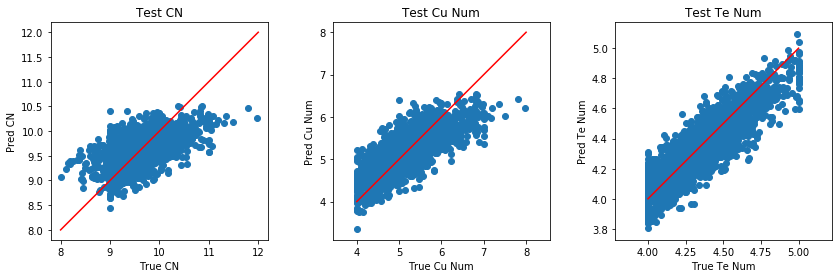

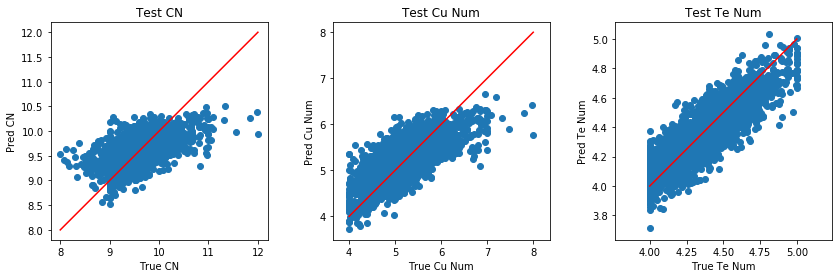

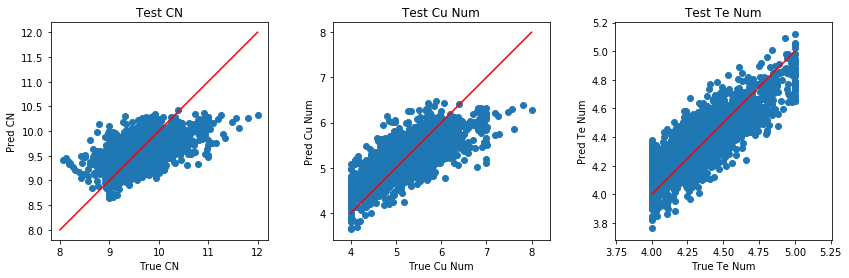

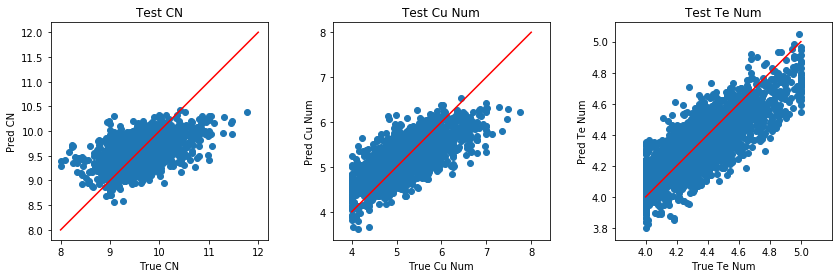

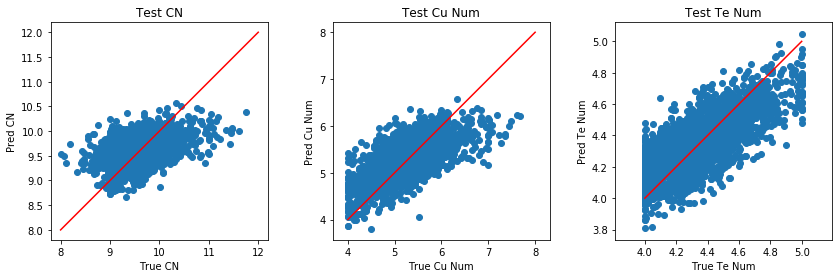

In [15]:
MLP_per_noise_1_2(df, Noise_STD, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)

In [16]:
print(rmse_CN_master_list_1_2)

[0.10391255660062752, 0.2022422383805275, 0.26918861545585, 0.3113381960567705, 0.3321218417034547, 0.34957860408916686, 0.3617833147688454, 0.36236308314325194, 0.37030680187394915, 0.3764807358368953, 0.3876255743036833]


In [20]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
rmse_CN_master_list_2 = []
score_CN_master_list_2 = []
rmse_Cu_master_list_2 = []
score_Cu_master_list_2 = []
rmse_Te_master_list_2 = []
score_Te_master_list_2 = []

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.027288
1   0.014044
2   0.011442
3   0.011603
4   0.010109
5   0.009575
6   0.008929
7   0.007927
8   0.008072
9   0.010174
10  0.007693
11  0.008360
12  0.008146
13  0.008416
14  0.007353
15  0.007753
16  0.007297
17  0.007613
18  0.007332
19  0.007671
20  0.007058
21  0.008253
22  0.008210
23  0.007435
24  0.006846
25  0.007686
26  0.007768
27  0.007471
28  0.007060
29  0.007128
30  0.007315
31  0.006896
32  0.007506
33  0.007447
34  0.006756
35  0.007283
36  0.007064
37  0.007292
38  0.006758
39  0.007254
40  0.007270
41  0.006626
42  0.008147
43  0.007691
44  0.007876
45  0.006827
46  0.006410
47  0.006647
48  0.007404
49  0.007323
50  0.007356
51  0.006884
52  0.006360
53  0.007142
54  0.006668
55  0.006356
56  0.006836
57  0.007183
58  0.007118
59  0.007126
60  0.007036
61  0.006559
62  0.007090
63  0.006915
64  0.006300
65  0.007437
66  0.006557
67  0.007224
68  0.006775
69  0.006808
70  0.007335
71  0.006758
72  0.006573
73  0.006731
74  0.007366
75  0.007184

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.048554
1   0.033625
2   0.029367
3   0.029833
4   0.029366
5   0.027941
6   0.028275
7   0.028014
8   0.027717
9   0.027264
10  0.027238
11  0.026977
12  0.027701
13  0.027064
14  0.028966
15  0.027247
16  0.026618
17  0.026712
18  0.026578
19  0.025703
20  0.025321
21  0.026137
22  0.026695
23  0.026544
24  0.025795
25  0.028120
26  0.025034
27  0.025641
28  0.028225
29  0.026588
30  0.026468
31  0.026092
32  0.026089
33  0.025004
34  0.026272
35  0.025824
36  0.025526
37  0.024311
38  0.025809
39  0.025136
40  0.024907
41  0.024532
42  0.026215
43  0.024391
44  0.026437
45  0.025449
46  0.024244
47  0.027119
48  0.024979
49  0.024784
50  0.025197
51  0.025368
52  0.022271
53  0.023594
54  0.023476
55  0.022863
56  0.023120
57  0.023436
58  0.025221
59  0.025349
60  0.024218
61  0.023903
62  0.023433
63  0.023213
64  0.023703
65  0.025021
66  0.025082
67  0.025693
68  0.024154
69  0.024069
70  0.022851
71  0.025846
72  0.022860
73  0.022566
74  0.024945
75  0.023965

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.083058
1   0.042147
2   0.040896
3   0.040166
4   0.040133
5   0.039291
6   0.037367
7   0.038398
8   0.039605
9   0.038793
10  0.037877
11  0.038659
12  0.038054
13  0.038784
14  0.038372
15  0.038201
16  0.039043
17  0.038840
18  0.037723
19  0.038398
20  0.038967
21  0.039137
22  0.038534
23  0.038523
24  0.037892
25  0.038089
26  0.037905
27  0.038337
28  0.038388
29  0.037722
30  0.037824
31  0.038484
32  0.036419
33  0.037662
34  0.037230
35  0.038249
36  0.037848
37  0.039083
38  0.038431
39  0.038274
40  0.037679
41  0.038417
42  0.037503
43  0.037988
44  0.037315
45  0.037334
46  0.037050
47  0.037316
48  0.036816
49  0.037461
50  0.037423
51  0.036721
52  0.037360
53  0.038754
54  0.037597
55  0.036709
56  0.037542
57  0.038046
58  0.037712
59  0.036981
60  0.036426
61  0.038619
62  0.038465
63  0.037178
64  0.037890
65  0.037580
66  0.037255
67  0.037364
68  0.037757
69  0.038067
70  0.037652
71  0.037568
72  0.037561
73  0.037570
74  0.037454
75  0.036563

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.075709
1   0.048777
2   0.049348
3   0.044662
4   0.044029
5   0.043407
6   0.043260
7   0.043216
8   0.043404
9   0.043553
10  0.043862
11  0.043557
12  0.043438
13  0.043083
14  0.043836
15  0.043121
16  0.042702
17  0.043761
18  0.042723
19  0.043017
20  0.043903
21  0.043884
22  0.043976
23  0.043021
24  0.043599
25  0.043257
26  0.042892
27  0.043416
28  0.043263
29  0.043018
30  0.042939
31  0.043848
32  0.043473
33  0.043043
34  0.042730
35  0.042957
36  0.043170
37  0.043864
38  0.044045
39  0.043563
40  0.042350
41  0.043644
42  0.042943
43  0.041984
44  0.042956
45  0.043552
46  0.042763
47  0.042792
48  0.042737
49  0.043029
50  0.042443
51  0.042881
52  0.042433
53  0.042400
54  0.043453
55  0.042486
56  0.042699
57  0.043007
58  0.042760
59  0.043215
60  0.043509
61  0.043002
62  0.042488
63  0.042979
64  0.042985
65  0.041834
66  0.042836
67  0.042516
68  0.042830
69  0.043186
70  0.042805
71  0.043694
72  0.042613
73  0.042571
74  0.042943
75  0.043449

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.087640
1   0.054040
2   0.056493
3   0.046787
4   0.047465
5   0.046205
6   0.045901
7   0.046265
8   0.046350
9   0.046659
10  0.045797
11  0.045746
12  0.045869
13  0.045432
14  0.046306
15  0.045404
16  0.045908
17  0.046368
18  0.046029
19  0.045549
20  0.046304
21  0.046326
22  0.046515
23  0.045986
24  0.045794
25  0.045704
26  0.045816
27  0.046034
28  0.046790
29  0.046524
30  0.046019
31  0.047003
32  0.045998
33  0.046607
34  0.045608
35  0.046849
36  0.045549
37  0.046364
38  0.046362
39  0.045397
40  0.045778
41  0.045822
42  0.045325
43  0.046328
44  0.045659
45  0.046634
46  0.045852
47  0.045520
48  0.045396
49  0.045523
50  0.046086
51  0.045608
52  0.045469
53  0.046457
54  0.046304
55  0.046140
56  0.045315
57  0.045454
58  0.045846
59  0.045460
60  0.045789
61  0.045309
62  0.045581
63  0.045039
64  0.045862
65  0.045681
66  0.045868
67  0.046007
68  0.045865
69  0.044960
70  0.045713
71  0.045915
72  0.045784
73  0.044983
74  0.046040
75  0.045975

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.083354
1   0.058278
2   0.061492
3   0.049021
4   0.049167
5   0.048368
6   0.047823
7   0.048420
8   0.048026
9   0.048338
10  0.047871
11  0.048182
12  0.048323
13  0.047923
14  0.048625
15  0.048515
16  0.048194
17  0.048715
18  0.048537
19  0.047625
20  0.048604
21  0.048506
22  0.047999
23  0.048063
24  0.048493
25  0.048122
26  0.047921
27  0.048578
28  0.048003
29  0.048321
30  0.047484
31  0.048550
32  0.048524
33  0.048375
34  0.048244
35  0.048659
36  0.048337
37  0.048363
38  0.048549
39  0.047829
40  0.048179
41  0.048463
42  0.047847
43  0.048419
44  0.048075
45  0.047982
46  0.048142
47  0.047755
48  0.047756
49  0.048056
50  0.047933
51  0.048245
52  0.048116
53  0.048695
54  0.049194
55  0.047660
56  0.048163
57  0.048369
58  0.047641
59  0.047874
60  0.048111
61  0.048506
62  0.047607
63  0.048924
64  0.047788
65  0.048468
66  0.048307
67  0.048145
68  0.047531
69  0.048271
70  0.048464
71  0.048389
72  0.048215
73  0.048076
74  0.048394
75  0.048500

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.090396
1   0.064882
2   0.069201
3   0.055226
4   0.054030
5   0.053327
6   0.052991
7   0.053283
8   0.053630
9   0.053126
10  0.053276
11  0.053348
12  0.054180
13  0.053901
14  0.052900
15  0.053196
16  0.052705
17  0.052954
18  0.053460
19  0.053240
20  0.053482
21  0.053032
22  0.052812
23  0.053578
24  0.053448
25  0.053413
26  0.053211
27  0.053747
28  0.053227
29  0.053577
30  0.053338
31  0.053535
32  0.053296
33  0.053496
34  0.053934
35  0.053505
36  0.053681
37  0.053193
38  0.053534
39  0.053589
40  0.052589
41  0.053528
42  0.053383
43  0.053013
44  0.053183
45  0.053499
46  0.053945
47  0.053201
48  0.053134
49  0.053034
50  0.052703
51  0.053541
52  0.053874
53  0.053372
54  0.054266
55  0.053355
56  0.053982
57  0.053803
58  0.053353
59  0.053964
60  0.053435
61  0.053378
62  0.053032
63  0.053451
64  0.053163
65  0.053025
66  0.053337
67  0.052858
68  0.053695
69  0.053002
70  0.054633
71  0.053946
72  0.053498
73  0.052877
74  0.053123
75  0.053088

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.087685
1   0.067775
2   0.079258
3   0.057234
4   0.056178
5   0.055695
6   0.055724
7   0.055253
8   0.055214
9   0.056539
10  0.055772
11  0.055378
12  0.056196
13  0.056156
14  0.055800
15  0.055580
16  0.055809
17  0.056015
18  0.056071
19  0.055636
20  0.055744
21  0.057120
22  0.055589
23  0.055527
24  0.056138
25  0.055562
26  0.056356
27  0.055954
28  0.055580
29  0.056065
30  0.055364
31  0.056493
32  0.055516
33  0.055692
34  0.055846
35  0.056057
36  0.056440
37  0.056135
38  0.055369
39  0.056131
40  0.055641
41  0.055224
42  0.055330
43  0.056433
44  0.056128
45  0.056342
46  0.056571
47  0.056316
48  0.055553
49  0.056751
50  0.055353
51  0.055477
52  0.056336
53  0.056030
54  0.056156
55  0.056174
56  0.056090
57  0.056250
58  0.055167
59  0.055830
60  0.056572
61  0.055330
62  0.055524
63  0.056085
64  0.056105
65  0.055371
66  0.055399
67  0.055559
68  0.055806
69  0.057154
70  0.055851
71  0.056347
72  0.055529
73  0.056026
74  0.056100
75  0.056129

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


           0
0   0.090494
1   0.069604
2   0.085724
3   0.058778
4   0.057808
5   0.057241
6   0.057517
7   0.056997
8   0.057369
9   0.056935
10  0.057139
11  0.057064
12  0.057635
13  0.058199
14  0.058003
15  0.056406
16  0.056515
17  0.057275
18  0.057497
19  0.057846
20  0.057422
21  0.058241
22  0.057129
23  0.057081
24  0.056938
25  0.057618
26  0.056475
27  0.058018
28  0.057240
29  0.057175
30  0.057292
31  0.057233
32  0.056793
33  0.056865
34  0.057035
35  0.057851
36  0.057023
37  0.057320
38  0.057599
39  0.058097
40  0.057410
41  0.057424
42  0.056549
43  0.057144
44  0.057267
45  0.056885
46  0.057448
47  0.057523
48  0.057026
49  0.056800
50  0.057269
51  0.057552
52  0.057346
53  0.057403
54  0.057638
55  0.057334
56  0.057987
57  0.058062
58  0.058220
59  0.057725
60  0.056746
61  0.057890
62  0.057698
63  0.056826
64  0.057928
65  0.057432
66  0.057452
67  0.057193
68  0.057569
69  0.057243
70  0.057760
71  0.057665
72  0.058071
73  0.056439
74  0.058484
75  0.057249

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached an

           0
0   0.088589
1   0.071524
2   0.088154
3   0.061686
4   0.060745
5   0.058966
6   0.060032
7   0.060087
8   0.059328
9   0.060107
10  0.059071
11  0.058852
12  0.060455
13  0.058979
14  0.059704
15  0.059887
16  0.058965
17  0.059641
18  0.059093
19  0.058722
20  0.059519
21  0.060602
22  0.059354
23  0.059481
24  0.059760
25  0.060470
26  0.059410
27  0.059120
28  0.058825
29  0.059803
30  0.060812
31  0.059322
32  0.060057
33  0.059127
34  0.059508
35  0.060391
36  0.060128
37  0.059212
38  0.058504
39  0.060315
40  0.059196
41  0.059198
42  0.059538
43  0.059404
44  0.060317
45  0.059660
46  0.059516
47  0.060169
48  0.059180
49  0.059637
50  0.060320
51  0.058785
52  0.059954
53  0.059990
54  0.060617
55  0.059833
56  0.058853
57  0.060105
58  0.059843
59  0.059625
60  0.059160
61  0.059986
62  0.060754
63  0.059584
64  0.058964
65  0.059713
66  0.059147
67  0.059994
68  0.059719
69  0.059940
70  0.059373
71  0.060539
72  0.059682
73  0.059749
74  0.060087
75  0.059182

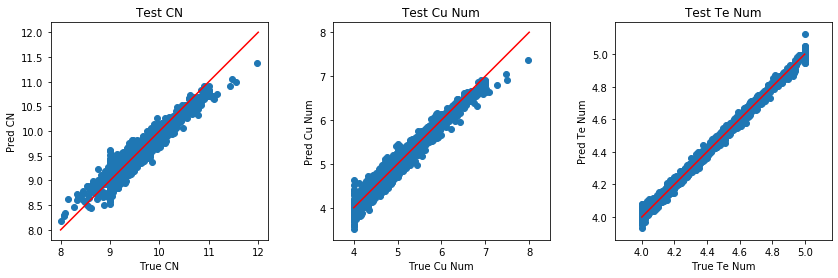

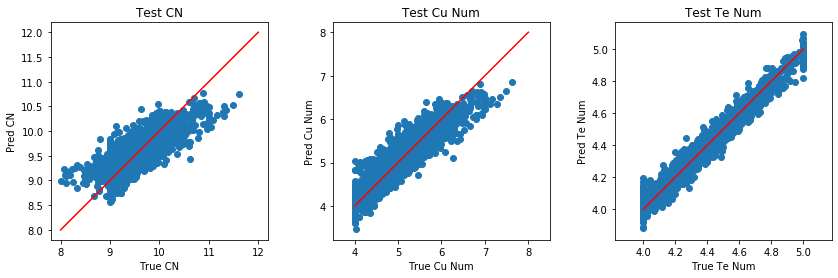

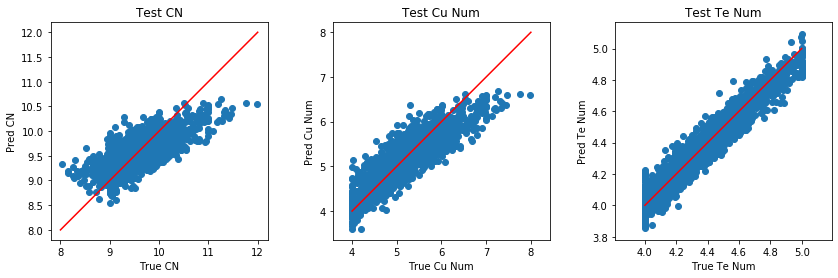

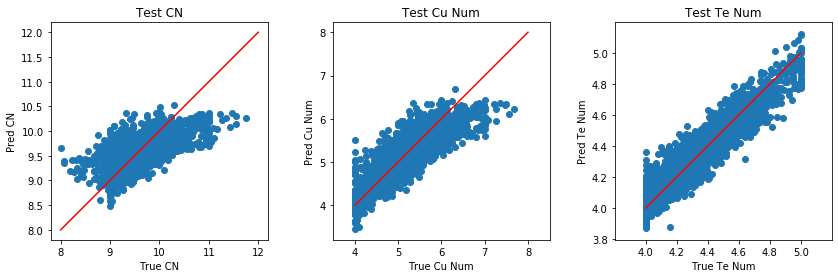

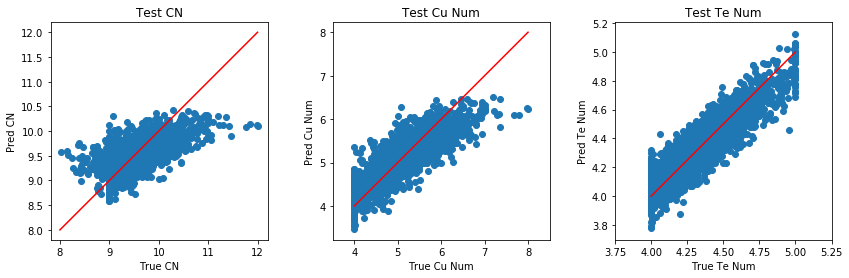

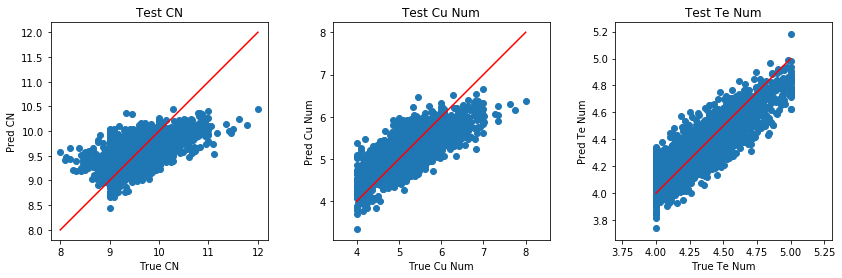

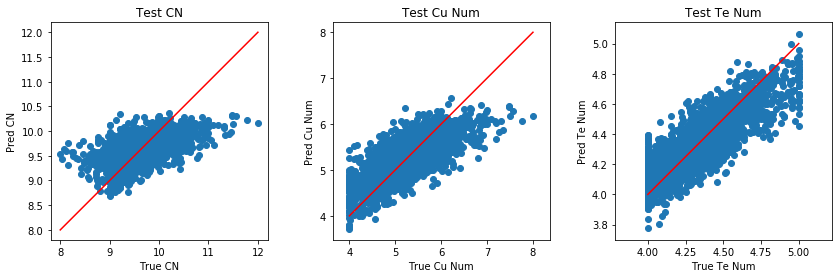

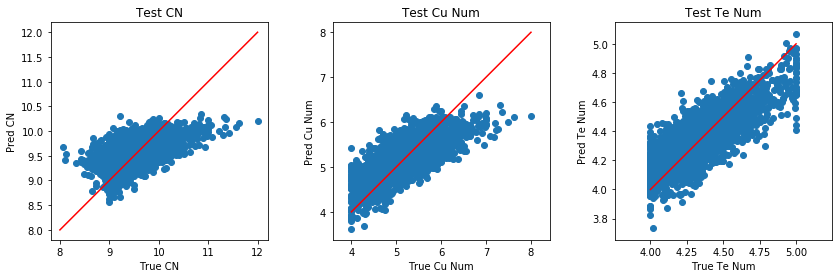

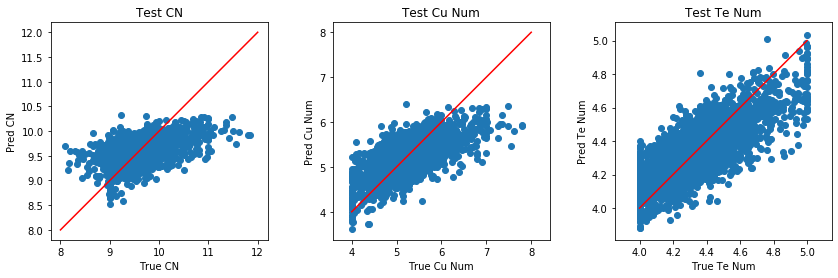

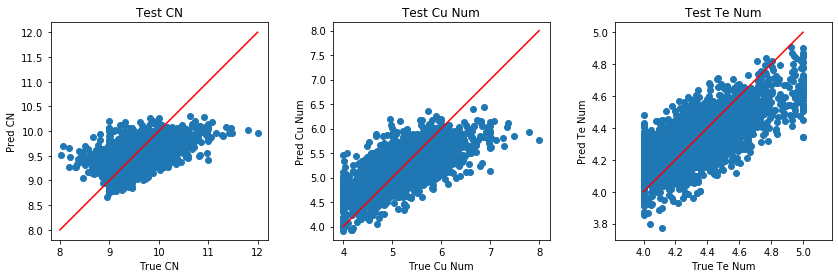

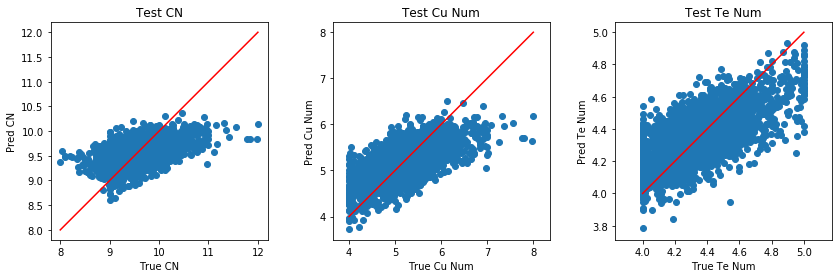

In [23]:
MLP_per_noise_2(df, Noise_STD, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)

In [59]:
print(rmse_CN_master_list_2)

[0.02051943088629084, 0.031199753976409242, 0.046142342811294104, 0.06065657129741004, 0.07650516434033315, 0.08901577486859087, 0.09876135085793751, 0.11097242881168434, 0.12096920915746386, 0.1337828879438168, 0.14022001676165544, 0.018099559838948877, 0.04531565365374283, 0.06083427944232546, 0.08498903072632014, 0.0999152381217804, 0.11596845016292438, 0.12549827806805305, 0.13792807625106132, 0.14537884125535275, 0.15724624684344354, 0.16012332335381074]
[]


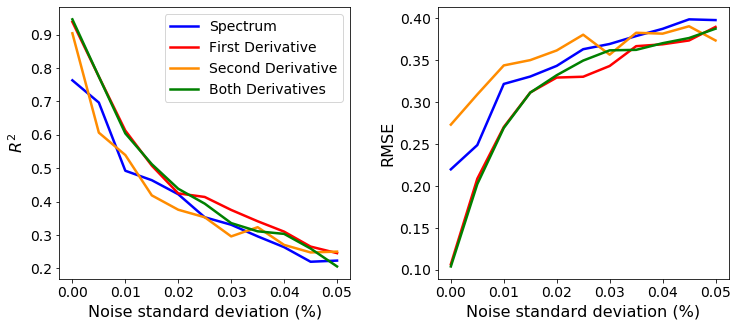

In [42]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(Noise_STD, score_CN_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(Noise_STD, score_CN_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(Noise_STD, score_CN_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(Noise_STD, score_CN_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise standard deviation (%)', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(Noise_STD, rmse_CN_master_list, c='blue', lw=2.5)
ax2.plot(Noise_STD, rmse_CN_master_list_1, c='red', lw=2.5)
ax2.plot(Noise_STD, rmse_CN_master_list_2, c='darkorange', lw=2.5)
ax2.plot(Noise_STD, rmse_CN_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Noise standard deviation (%)', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

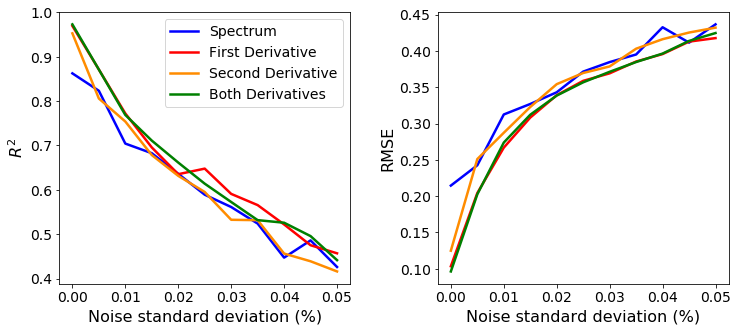

In [68]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(Noise_STD, score_Cu_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(Noise_STD, score_Cu_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(Noise_STD, score_Cu_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(Noise_STD, score_Cu_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise standard deviation (%)', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(Noise_STD, rmse_Cu_master_list, c='blue', lw=2.5)
ax2.plot(Noise_STD, rmse_Cu_master_list_1, c='red', lw=2.5)
ax2.plot(Noise_STD, rmse_Cu_master_list_2, c='darkorange', lw=2.5)
ax2.plot(Noise_STD, rmse_Cu_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Noise standard deviation (%)', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

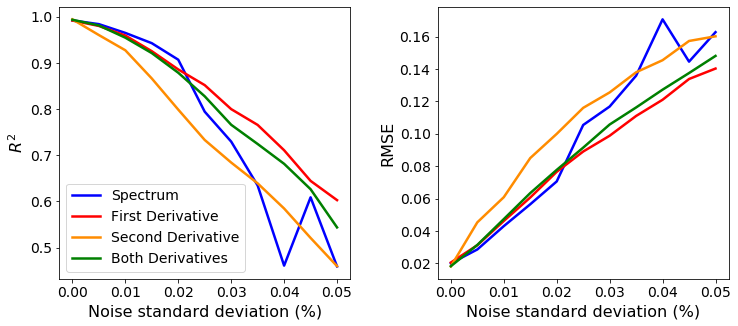

In [67]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(Noise_STD, score_Te_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(Noise_STD, score_Te_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(Noise_STD, score_Te_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(Noise_STD, score_Te_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise standard deviation (%)', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(Noise_STD, rmse_Te_master_list, c='blue', lw=2.5)
ax2.plot(Noise_STD, rmse_Te_master_list_1, c='red', lw=2.5)
ax2.plot(Noise_STD, rmse_Te_master_list_2, c='darkorange', lw=2.5)
ax2.plot(Noise_STD, rmse_Te_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Noise standard deviation (%)', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# ZERO NOISE - Estimators=1000

## SPECTRUM

In [25]:
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
y = df[['CN', 'Num Cu', 'Num Te']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=519)

In [27]:
rf = train_rf(X_train, y_train)

In [42]:
test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, rf)

training mse =  [0.0010692084745233612, 0.0010058588147084655, 7.518714507821849e-05]
testing mse = [0.008400334263690353, 0.007955834788120085, 0.00053327067582158]
training R2 = [0.9943276249886033, 0.9969752733240271, 0.9985345464202113]
testing R2 = [0.9587914914319863, 0.977312982750778, 0.9898996995188638]


## 1ST DERIVATIVE

In [29]:
np.shape(y)

(10000, 3)

In [19]:
xs = np.linspace(8970, 9050, 1000)

In [21]:
df1, df2, df3 = derivatives(X, xs)

KeyError: (0, 1)

In [32]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1, y, test_size=0.20, random_state=519)

In [33]:
rf1 = train_rf(X_train1, y_train1)

In [43]:
test_mse_list1, test_score_list1, y_test_pred1 = analyse_layer(X_train1, X_test1, y_train1, y_test1, rf1)

training mse =  [0.001751345149962175, 0.0016725221193510658, 5.959784852949481e-05]
testing mse = [0.013471831250479249, 0.012847274977180351, 0.0004988218567277475]
training R2 = [0.9907087469827576, 0.9949705443780179, 0.9988383934463213]
testing R2 = [0.9339128591689727, 0.9633644542935941, 0.9905521700930838]


## 2ND DERIVATIVE

In [35]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2, y, test_size=0.20, random_state=519)

In [36]:
rf2 = train_rf(X_train2, y_train2)

In [44]:
test_mse_list2, test_score_list2, y_test_pred2 = analyse_layer(X_train2, X_test2, y_train2, y_test2, rf2)

training mse =  [0.0012056004806997663, 0.0011237521212011348, 6.454213506669343e-05]
testing mse = [0.009261679134135154, 0.008700769109569073, 0.0005572434643825817]
training R2 = [0.9936040368147121, 0.9966207553500803, 0.9987420256111295]
testing R2 = [0.9545660955894468, 0.9751887131737518, 0.9894456479859086]


## BOTH DERIVATIVES

In [38]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df3, y, test_size=0.20, random_state=519)

In [39]:
rf3 = train_rf(X_train3, y_train3)

In [45]:
test_mse_list3, test_score_list3, y_test_pred3 = analyse_layer(X_train3, X_test3, y_train3, y_test3, rf3)

training mse =  [0.0011469504572530918, 0.001089717172438454, 4.604981242528496e-05]
testing mse = [0.008887490917298617, 0.008345147801592439, 0.00038872145668726696]
training R2 = [0.9939151874792868, 0.9967231021366596, 0.9991024547827022]
testing R2 = [0.9564017056801319, 0.9762028099923916, 0.992637503440523]


***

Test Different Number of Estimators for Spectrum
Estimators=10000

In [50]:
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
y = df[['CN', 'Num Cu', 'Num Te']]

In [51]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.20, random_state=519)

In [52]:
rf_ = train_rf(X_train, y_train)

In [53]:
test_mse_list_, test_score_list_, y_test_pred_ = analyse_layer(X_train_, X_test_, y_train_, y_test_, rf_)

training mse =  [0.0010596525455374348, 0.0009955975912396737, 7.430945584683342e-05]
testing mse = [0.008353405400437346, 0.007902868227012213, 0.000529752808409498]
training R2 = [0.9943783211943311, 0.9970061299372023, 0.9985516532384677]
testing R2 = [0.9590217047071661, 0.9774640232534392, 0.9899663289427677]


# Dependence on Data Set Size

In [7]:
size = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
rmse_CN_master_list = []
score_CN_master_list = []
rmse_Cu_master_list = []
score_Cu_master_list = []
rmse_Te_master_list = []
score_Te_master_list = []

training mse =  [0.00883265855977591, 0.008216791858514233, 0.0008012427575378496]
testing mse = [0.049362412660202824, 0.038338008597990955, 0.004913566966185413]
training R2 = [0.9635951450564285, 0.9795485774998078, 0.9847557658022653]
testing R2 = [0.6004921909973747, 0.7664511967120797, 0.8631054049790445]
training mse =  [0.0025033325295454835, 0.0024857605365994125, 0.00021478797418863281]
testing mse = [0.016897715924850554, 0.015264665798001655, 0.0009029454332035056]
training R2 = [0.9876702499738241, 0.9928455411424986, 0.9959665065371144]
testing R2 = [0.9101569975222787, 0.9551553786675946, 0.9804876516558428]
training mse =  [0.0022023045336264585, 0.0020953438870194713, 0.00016444400776191597]
testing mse = [0.016558109701077243, 0.015741988068360947, 0.0009913062810413212]
training R2 = [0.9882492332039915, 0.9936576570230791, 0.9967245126947928]
testing R2 = [0.9087404303280288, 0.9538972539896804, 0.9834288840008061]
training mse =  [0.001573439951227016, 0.0015206406

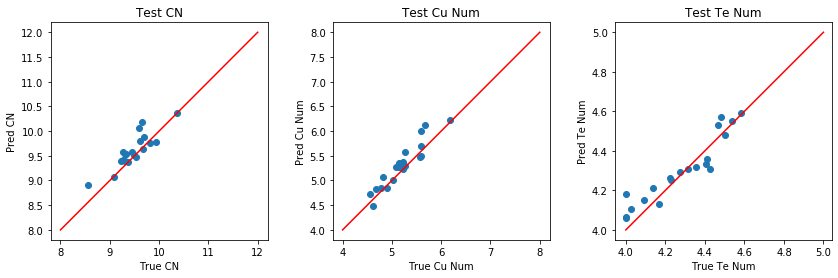

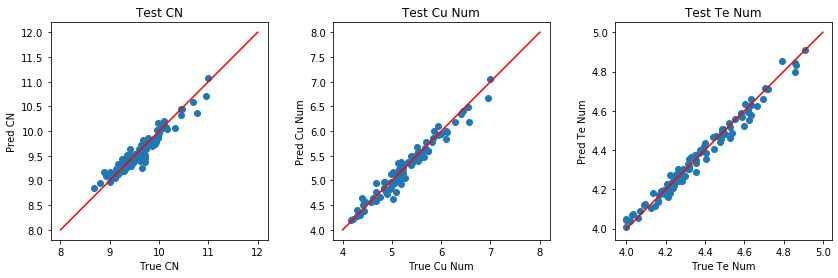

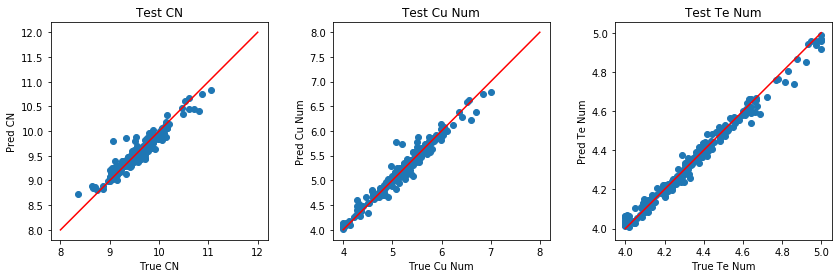

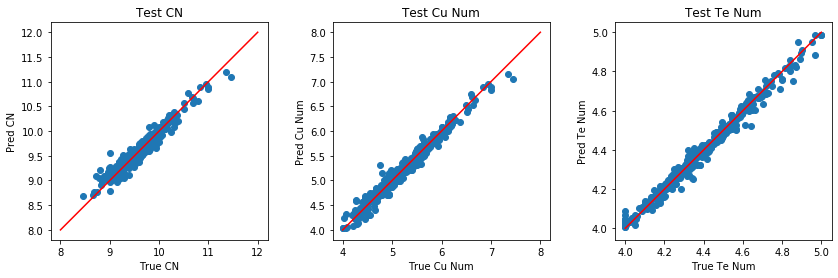

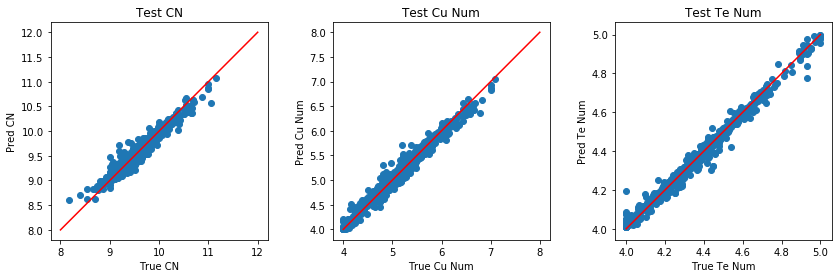

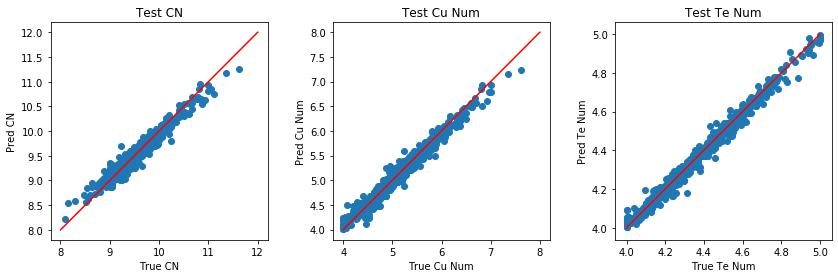

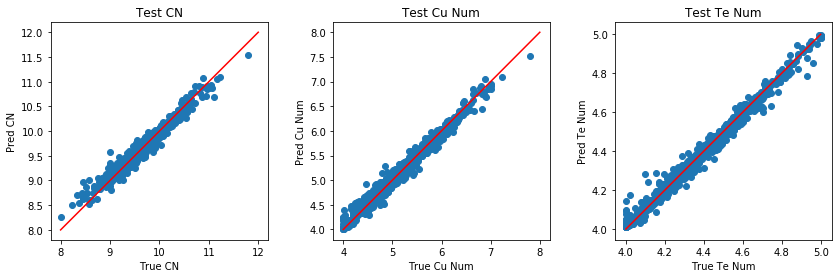

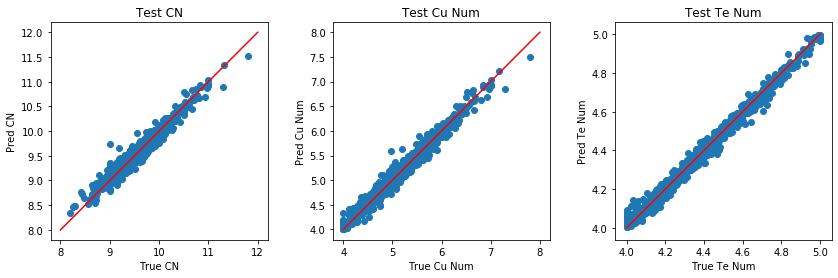

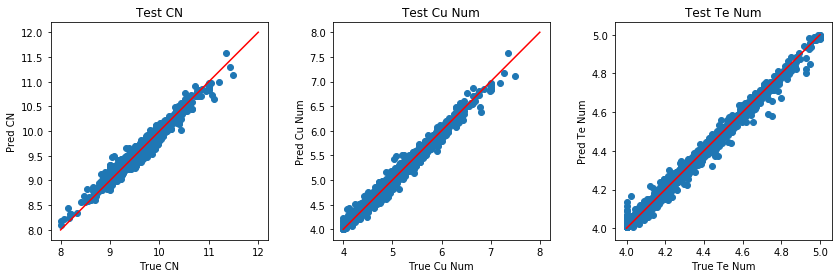

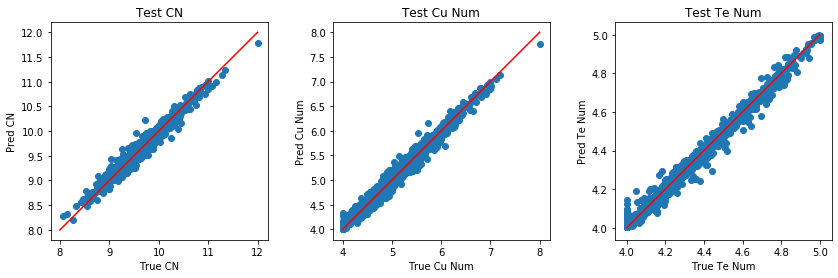

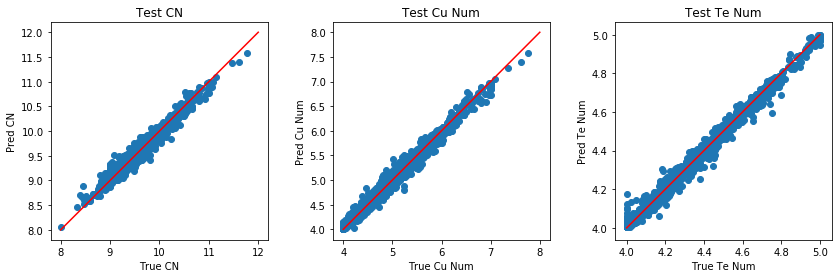

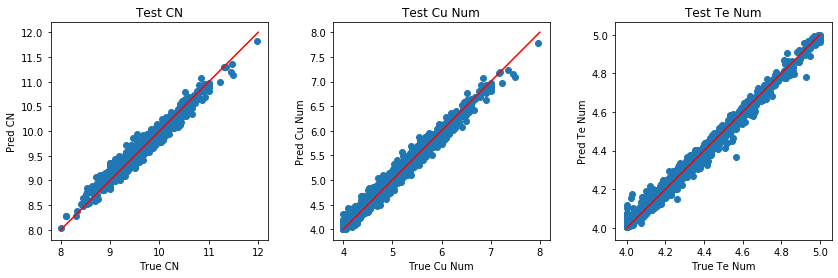

In [8]:
MLP_per_size_spectra(df, size, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

training mse =  [0.00604115000238517, 0.006125825739630423, 0.0004363119945858009]
testing mse = [0.14837014094751924, 0.1311049138340164, 0.005789080757910003]
training R2 = [0.9542962396404413, 0.9795485598368028, 0.9926474967261308]
testing R2 = [0.6053355576050632, 0.7620770533406049, 0.9174793965176298]
training mse =  [0.004561575885583856, 0.004790917027984018, 0.00022240241423550434]
testing mse = [0.04525492795145546, 0.05016651587127331, 0.0014436530300208764]
training R2 = [0.9705709029817395, 0.9839069486434271, 0.9958232123024637]
testing R2 = [0.8002830070513032, 0.880570848394324, 0.9756960928201465]
training mse =  [0.0039636426181886095, 0.004175515157787632, 0.00012624586543748536]
testing mse = [0.03728400192026035, 0.03969032889300365, 0.0015229147243049595]
training R2 = [0.9787898288887099, 0.9873729170247935, 0.9976637982015784]
testing R2 = [0.8248770027355622, 0.8873366456118543, 0.9734501605372078]
training mse =  [0.003317359270687215, 0.0034041612614160175, 

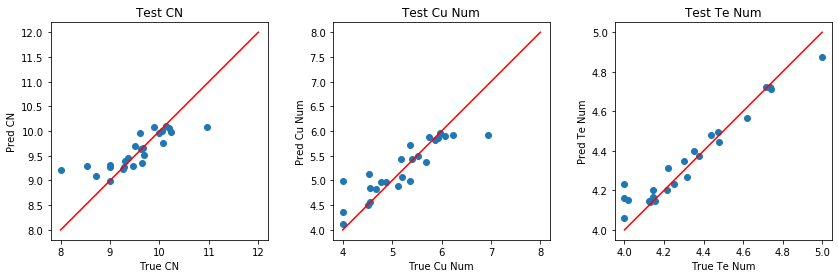

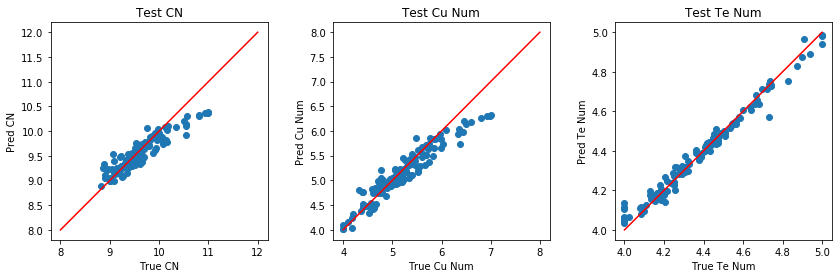

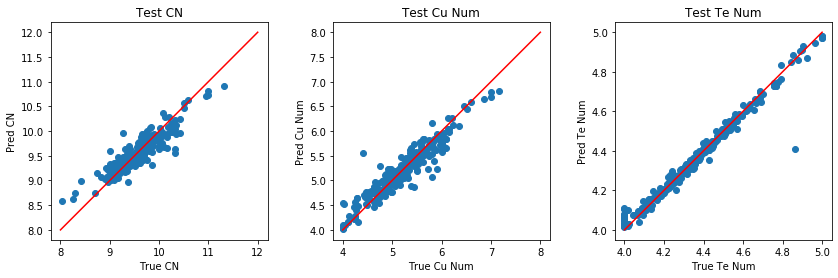

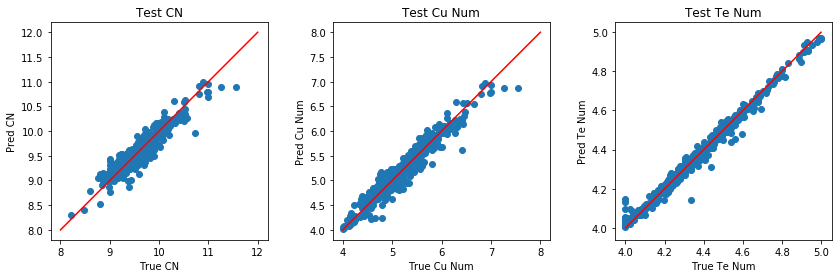

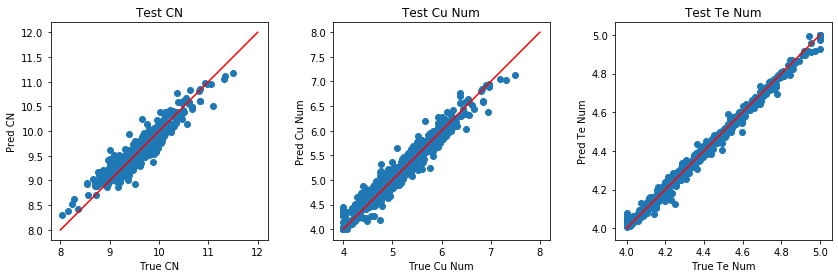

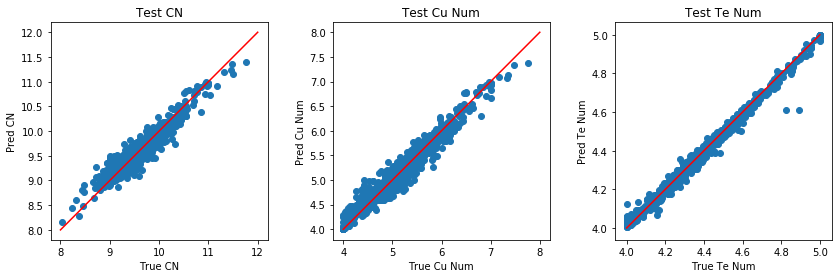

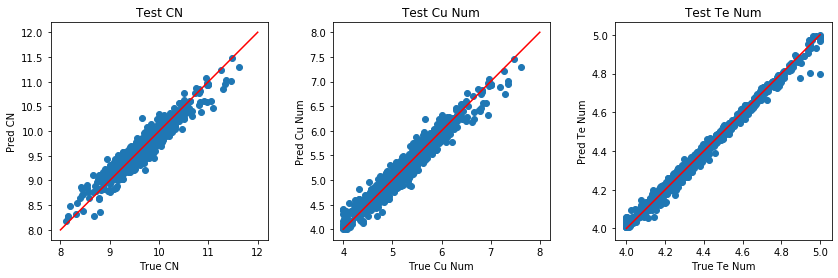

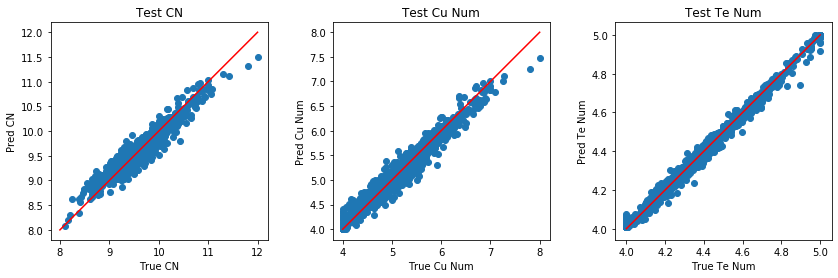

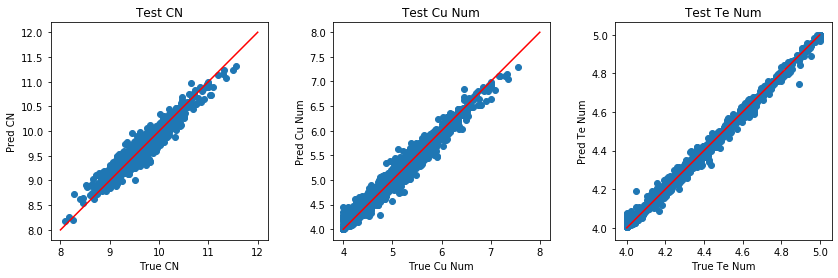

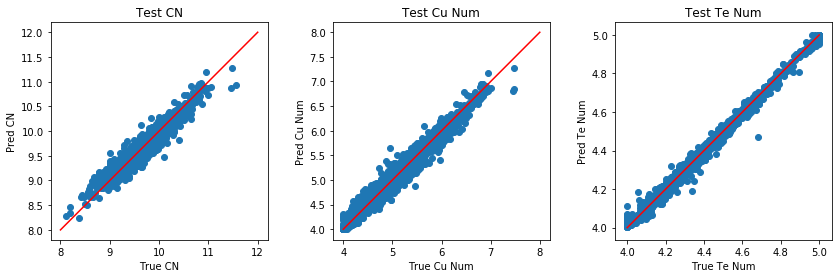

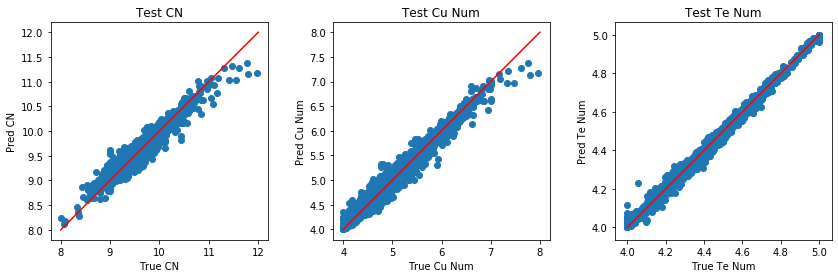

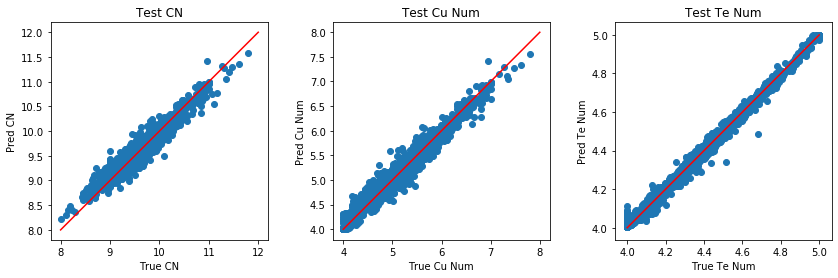

In [33]:
xs = np.linspace(8970, 9050, 1000)
MLP_per_size_1(df, size, xs, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

training mse =  [0.006761011777830418, 0.006528644409337937, 0.00046306316960181]
testing mse = [0.033767221120503704, 0.030452088312607994, 0.0022703974539333817]
training R2 = [0.9622958270271841, 0.9809529174604302, 0.9910686440759724]
testing R2 = [0.763904317879524, 0.8979914631085429, 0.9569685128725027]
training mse =  [0.0035441254195515393, 0.003231398797770637, 0.00017375603815283902]
testing mse = [0.026176541563045826, 0.02590024577147794, 0.0017290749149416994]
training R2 = [0.9805885547255757, 0.990413675711923, 0.9967873117318051]
testing R2 = [0.8843809621817964, 0.9413005707837662, 0.9743381078416598]
training mse =  [0.003048999720354214, 0.0029119146105730403, 0.00010060414319530662]
testing mse = [0.024976180368178832, 0.0242435784675962, 0.0006253817929268867]
training R2 = [0.9833838254624107, 0.9910572220668844, 0.9981415972316635]
testing R2 = [0.8718962725295609, 0.9300885139662964, 0.9881803863457161]
training mse =  [0.002496475740208008, 0.00241494549873553

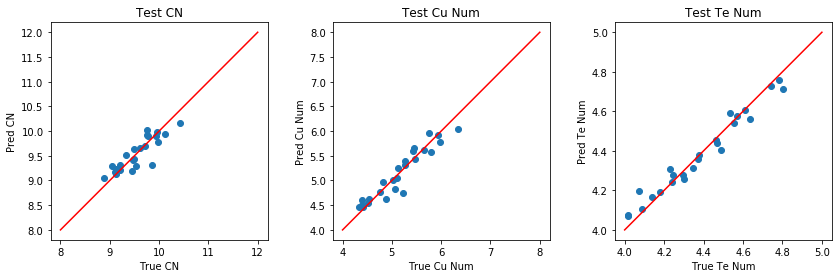

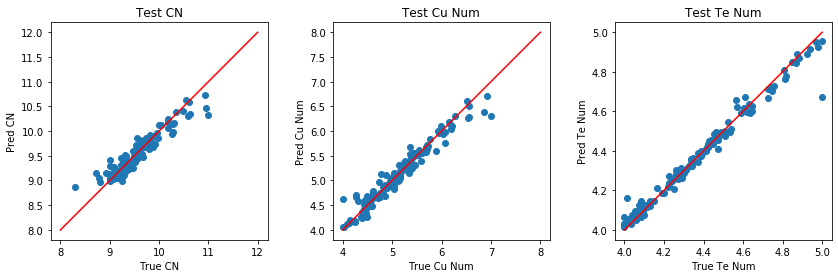

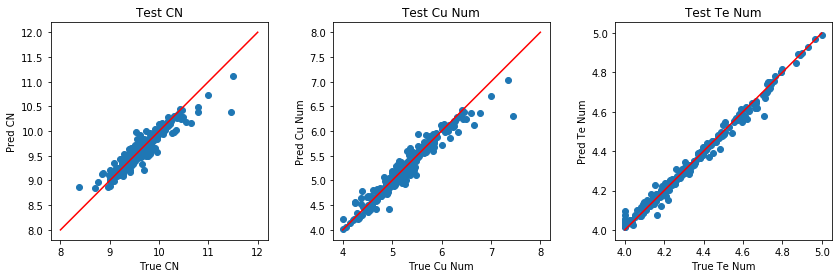

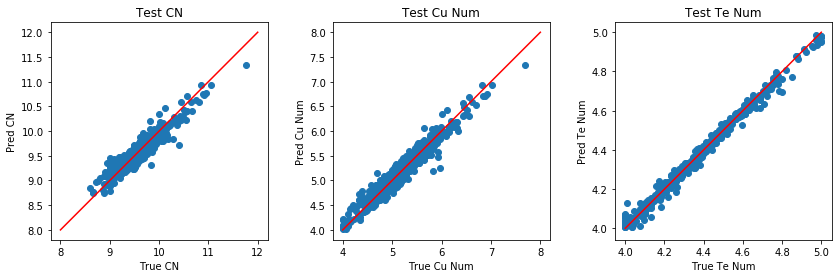

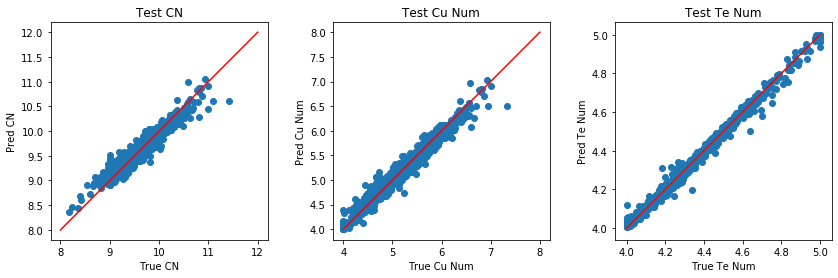

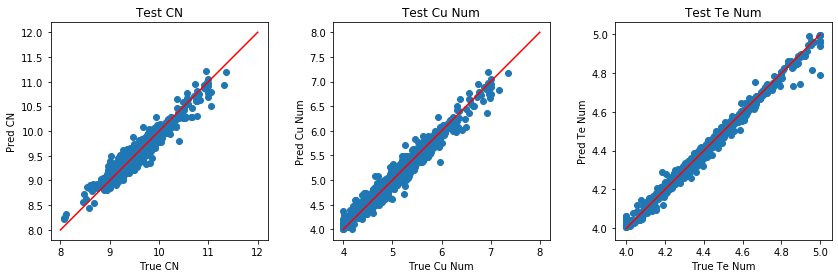

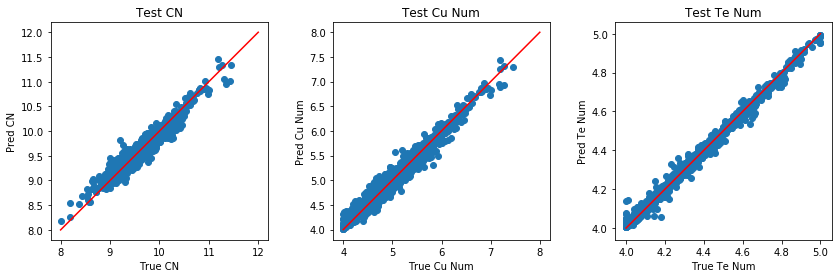

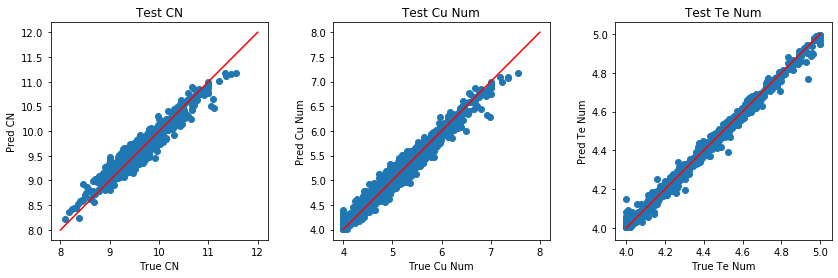

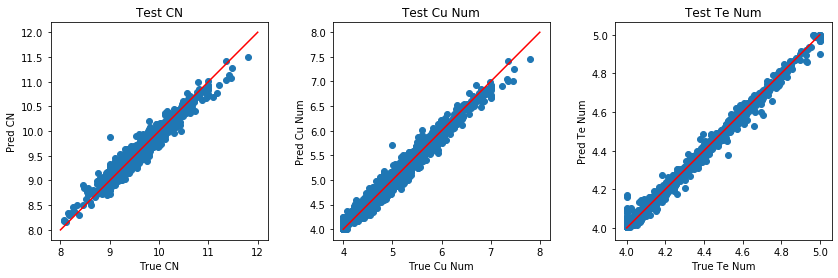

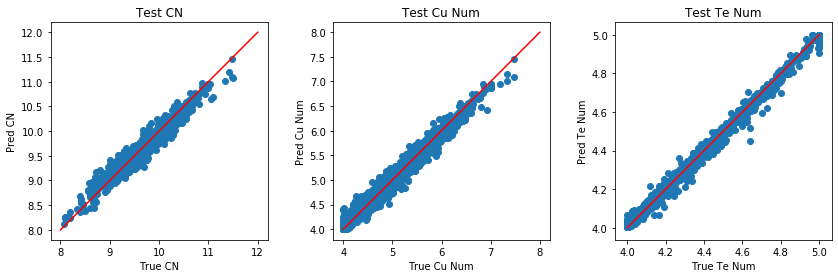

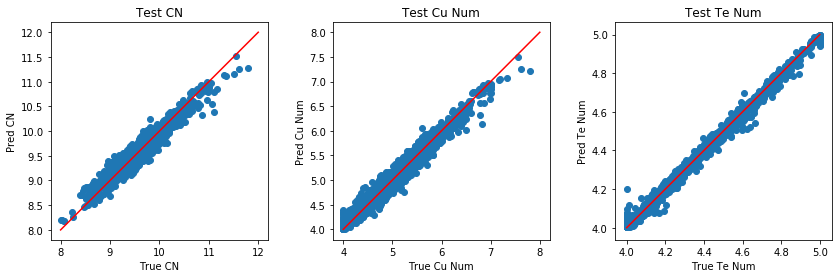

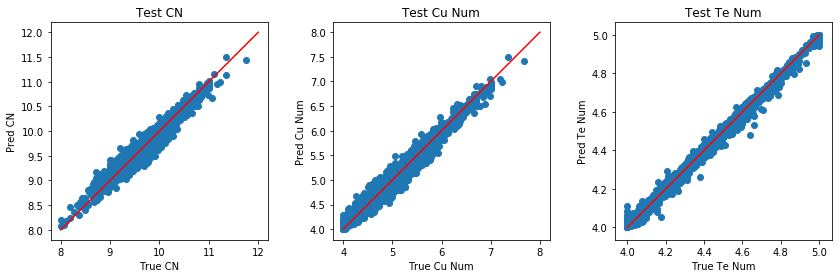

In [34]:
xs = np.linspace(8970, 9050, 1000)
MLP_per_size_2(df, size, xs, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

training mse =  [0.006655446929092222, 0.006581746219379195, 0.0005737896002206834]
testing mse = [0.03773446155553193, 0.03594383511475492, 0.002842071480646141]
training R2 = [0.9683173847105822, 0.9827187332014469, 0.990784866785582]
testing R2 = [0.3865527752136484, 0.7326372665220877, 0.933175633201921]
training mse =  [0.003731488779958645, 0.0035442349443842924, 0.00017989254416867474]
testing mse = [0.026406336848794437, 0.027005272815596667, 0.0009861480205506743]
training R2 = [0.9783417285614513, 0.9888160829880396, 0.996622762066289]
testing R2 = [0.8868177127793886, 0.932947396856131, 0.9804828568110777]
training mse =  [0.003440057218592473, 0.0034327425429661485, 0.0001153453339861926]
testing mse = [0.025670386606952336, 0.026529783314894743, 0.001307986245906937]
training R2 = [0.9822847136239158, 0.9899948800709791, 0.9977419271327735]
testing R2 = [0.8879231266856866, 0.9270654875846257, 0.9730552187006973]
training mse =  [0.0023361066990642975, 0.002244560502515897

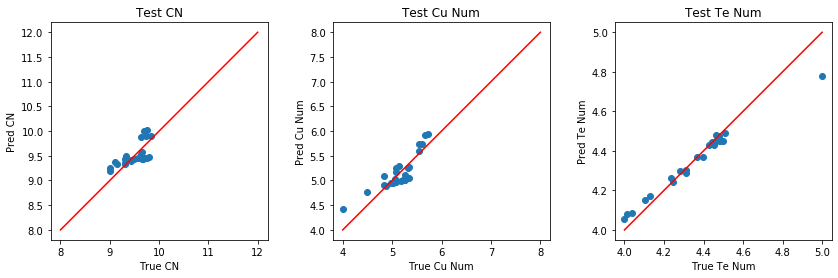

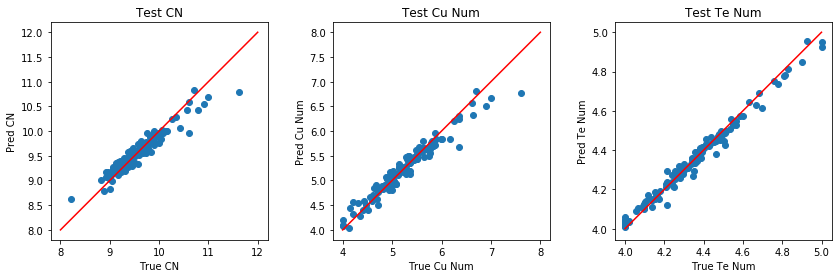

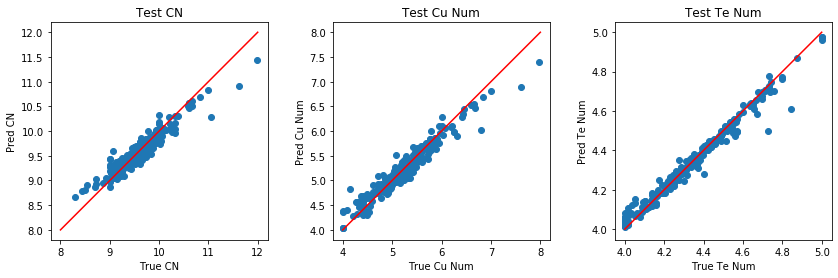

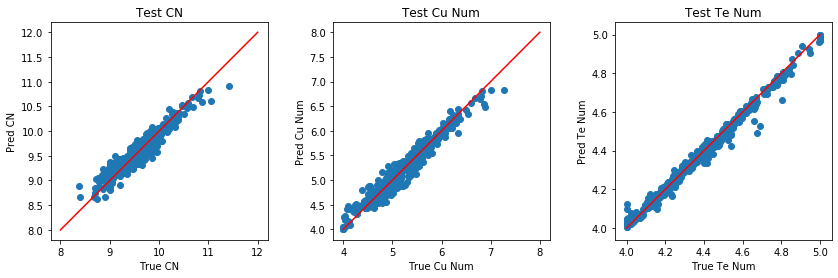

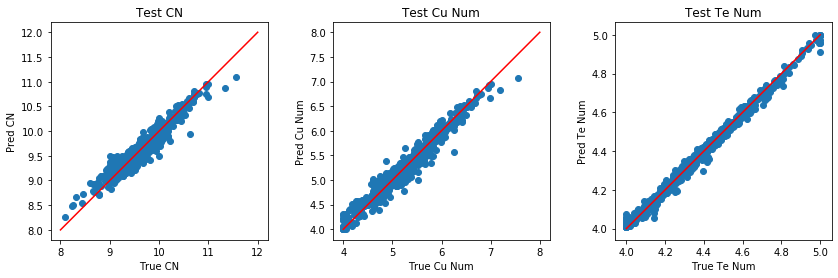

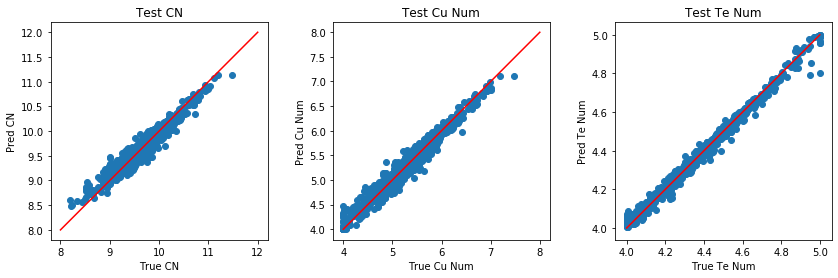

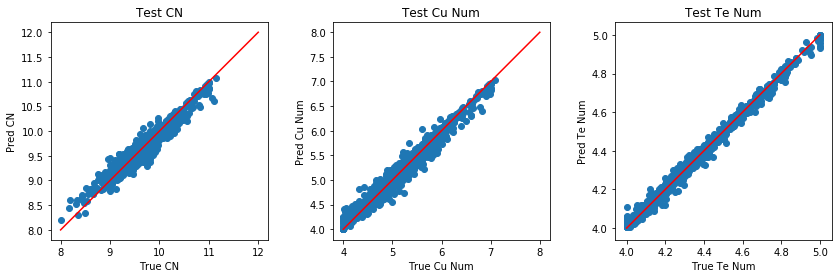

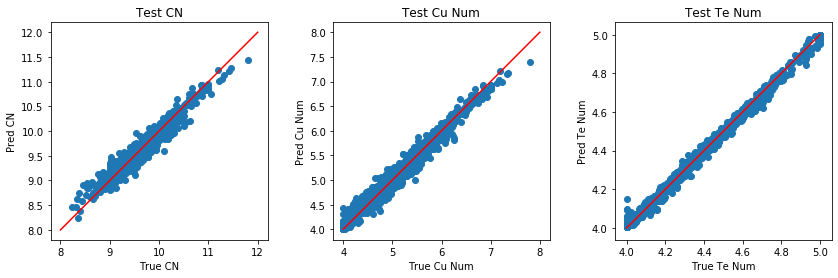

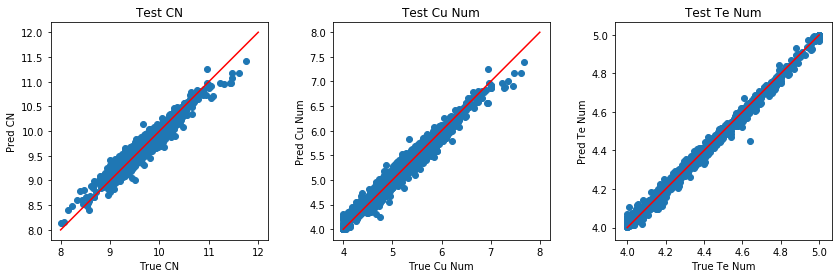

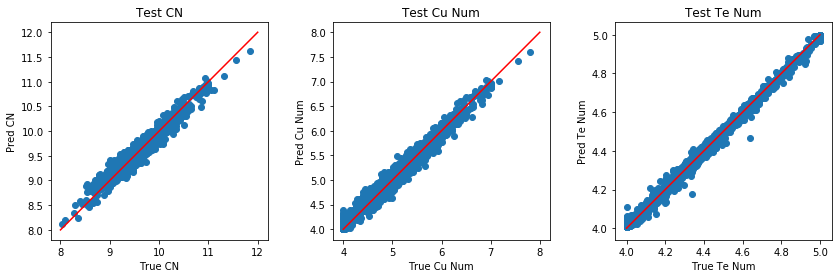

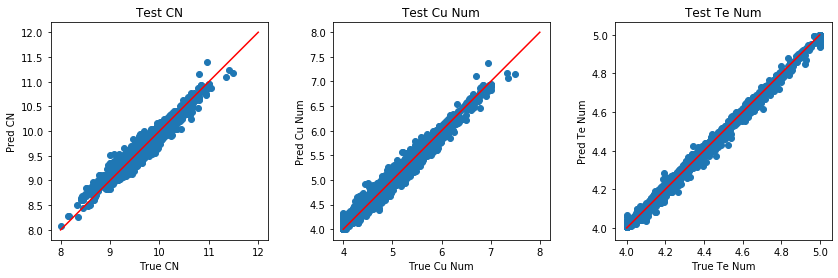

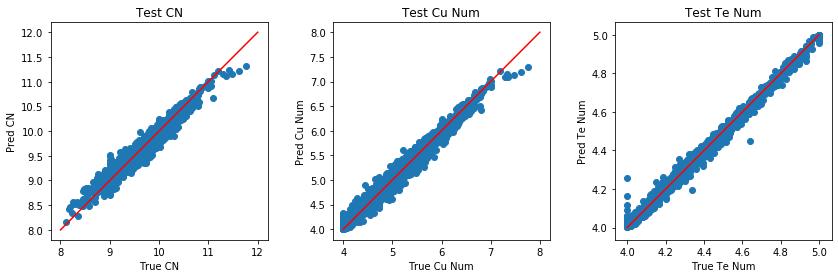

In [35]:
xs = np.linspace(8970, 9050, 1000)
MLP_per_size_1_2(df, size, xs, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

***

### Plots for data size dependence

In [13]:
spectra_rmse_list = [0.2221765349000718, 0.12999121479873382, 0.1286783186907462, 0.10612385361920915, 0.1090311281224209, 
                     0.10055365101519129, 0.09683995588355848, 0.0935415051915109, 0.09301987757904603, 0.08675033516916465,
                     0.08822232335760533, 0.08841178405632963] 

dx1_mse_list = [0.14837014094751924,0.04525492795145546, 0.03728400192026035, 0.021505214372927933, 0.022694138295960925, 
                0.019773114740844772, 0.01749264408637713, 0.01815528628787975, 0.014790169038147586, 0.015601986964876144, 
                0.015472031525763005, 0.01535853263439927]
dx1_rmse_list = np.sqrt(dx1_mse_list)

dx2_mse_list = [0.033767221120503704, 0.026176541563045826, 0.024976180368178832, 0.01865615054374132, 0.017526575536373618, 
                0.014865272065820168, 0.014506378985035519, 0.01468808803810166, 0.012821556961911316, 0.01291391492416469, 
                0.012953529997285112, 0.011969301319447467]
dx2_rmse_list = np.sqrt(dx2_mse_list)

dx1_2_mse_list = [0.03773446155553193, 0.026406336848794437, 0.025670386606952336, 0.017568264888597106, 0.016401350491143583, 
                  0.013706903624478241, 0.013749903106363048, 0.012348824527152772, 0.013301633182909276, 0.011633141642450056, 
                  0.012043346798270373, 0.011238806027780423]
dx1_2_rmse_list = np.sqrt(dx1_2_mse_list)

In [17]:
print(spectra_rmse_list)
print()
print(dx1_rmse_list)
print()
print(dx2_rmse_list)
print()
print(dx1_2_rmse_list)

[0.2221765349000718, 0.12999121479873382, 0.1286783186907462, 0.10612385361920915, 0.1090311281224209, 0.10055365101519129, 0.09683995588355848, 0.0935415051915109, 0.09301987757904603, 0.08675033516916465, 0.08822232335760533, 0.08841178405632963]

[0.38518845 0.21273206 0.19309066 0.14664656 0.15064574 0.14061691
 0.13225976 0.13474155 0.12161484 0.12490791 0.12438662 0.12392955]

[0.18375859 0.16179166 0.15803854 0.13658752 0.13238797 0.12192322
 0.12044243 0.12119442 0.11323231 0.11363941 0.11381358 0.1094043 ]

[0.1942536  0.16250027 0.16021981 0.13254533 0.12806776 0.11707649
 0.11725998 0.11112527 0.11533271 0.10785704 0.10974218 0.10601324]


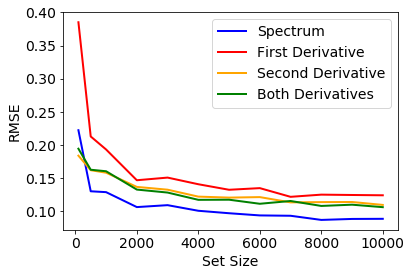

In [23]:
size = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plt.rcParams.update({'font.size': 14})
plt.plot(size, spectra_rmse_list, c='blue', lw=2, label='Spectrum')
plt.plot(size, dx1_rmse_list, c='red', lw=2, label='First Derivative')
plt.plot(size, dx2_rmse_list, c='orange', lw=2, label='Second Derivative')
plt.plot(size, dx1_2_rmse_list, c='green', lw=2, label='Both Derivatives')
plt.ylabel('RMSE')
plt.xlabel('Set Size')
plt.legend()
plt.show()

***

In [10]:
n_est = [100, 500, 1000, 2500, 5000, 7500, 10000]
mse_list = []
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
y = df[['CN']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=519)

for nums in n_est:
    rf = rfg(n_estimators=nums, random_state = 28)
    rf = rf.fit(X_train, y_train)
    y_predict = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    mse_list.append(mse)
    
print(mse_list)

/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[0.008854955081297074, 0.008739230457630844, 0.008733572516908957, 0.008728679675907895, 0.008741909082319812, 0.00873197875679508, 0.00873193383317515]


In [11]:
max_dep = [None, 2, 3, 5, 7, 10]
mse_list = []
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
y = df[['CN']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=519)

for nums in max_dep:
    rf = rfg(n_estimators=500, random_state = 28, max_depth=nums)
    rf = rf.fit(X_train, y_train)
    y_predict = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    mse_list.append(mse)
    
print(mse_list)

/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[0.008739230457630844, 0.0771579149419056, 0.046514674275754495, 0.021906305430565702, 0.013454977800510115, 0.009673281074516498]


In [12]:
max_dep = [12, 15, 20, 23, 25]
mse_list = []
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
y = df[['CN']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=519)

for nums in max_dep:
    rf = rfg(n_estimators=500, random_state = 28, max_depth=nums)
    rf = rf.fit(X_train, y_train)
    y_predict = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    mse_list.append(mse)
    
print(mse_list)

/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[0.008990254541116332, 0.008753940555218297, 0.008721312046669687, 0.008722202764601108, 0.008741599466705477]


In [17]:
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
y = df[['CN']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=519)

In [18]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 80, 90, 100, 110],
    'max_features': ["auto", 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 8],
    'n_estimators': [2500, 3000, 3500, 4000, 4500, 5000]
}
# Create a based model
rf = rfg()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/jpothoof/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 279.8min


In [ ]:
grid_search.best_params_

best_grid = grid_search.best_estimator_
print(best_grid)

In [ ]:
y_pred = best_grid.predict(X_test)

In [ ]:
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

In [11]:
rf = rfg(n_estimators=2500, random_state=28)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

/home/jpothoof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.008728679675907895
0.9571807668693794


In [20]:
def MLP_per_testsize_spectra(df, size, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise
    '''
    for entry in size:
        X_train, X_test, y_train, y_test, X_noise, y = noise_smooth(df, Noise=0, size=entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)
    print(rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

def MLP_per_testsize_1(df, size, x_axis, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1):

    for entry in size:
        _, _, _, _, X_smooth, y = noise_smooth(df, Noise=0, size=entry)
        df1, df2, df3, = derivatives(X_smooth, x_axis)
        X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size=entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)
    print(rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

def MLP_per_testsize_2(df, size, x_axis, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2):
    for entry in size:
        _, _, _, _, X_smooth, y = noise_smooth(df, Noise=0, size=entry)
        df1, df2, df3, = derivatives(X_smooth, x_axis)
        X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    print(rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    
    
def MLP_per_testsize_1_2(df, size, x_axis, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2):
    for entry in size:
        _, _, _, _, X_smooth, y = noise_smooth(df, Noise=0, size=entry)
        df1, df2, df3, = derivatives(X_smooth, x_axis)
        X_train, X_test, y_train, y_test = train_test_split(df3, y, test_size=entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)
    print(rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)

In [21]:
size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rmse_CN_master_list = []
score_CN_master_list = []
rmse_Cu_master_list = []
score_Cu_master_list = []
rmse_Te_master_list = []
score_Te_master_list = []

rmse_CN_master_list_1 = []
score_CN_master_list_1 = []
rmse_Cu_master_list_1 = []
score_Cu_master_list_1 = []
rmse_Te_master_list_1 = []
score_Te_master_list_1 = []

rmse_CN_master_list_2 = []
score_CN_master_list_2 = []
rmse_Cu_master_list_2 = []
score_Cu_master_list_2 = []
rmse_Te_master_list_2 = []
score_Te_master_list_2 = []

rmse_CN_master_list_1_2 = []
score_CN_master_list_1_2 = []
rmse_Cu_master_list_1_2 = []
score_Cu_master_list_1_2 = []
rmse_Te_master_list_1_2 = []
score_Te_master_list_1_2 = []

In [26]:
MLP_per_testsize_spectra(df, size, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

training mse =  [0.0010518466690609565, 0.000993543690992023, 7.051467431367092e-05]
testing mse = [0.0074071911525136255, 0.00699323722737815, 0.0005338487524008107]
training R2 = [0.9945170472725121, 0.9970440469254979, 0.9986263878194485]
testing R2 = [0.9608525370591096, 0.979261725915053, 0.9901473390161647]
training mse =  [0.00105710798626072, 0.00100398114301847, 7.245324343090631e-05]
testing mse = [0.00821142760712062, 0.007628609809396296, 0.0005350724666794275]
training R2 = [0.9944659374837286, 0.9970067951777307, 0.9985904551250597]
testing R2 = [0.957616894896371, 0.9775233798184577, 0.9898076442904126]
training mse =  [0.0011081703248314036, 0.0010498036510420458, 7.662345178341057e-05]
testing mse = [0.008003831903631443, 0.0075044137580596556, 0.0006273111462386018]
training R2 = [0.994244536842969, 0.9968871600737187, 0.9985208962212374]
testing R2 = [0.9577232663259556, 0.977520192118803, 0.9877455978187839]
training mse =  [0.0011203549248419644, 0.0010532878673642

In [27]:
xs = np.linspace(8970, 9050, 1000)
MLP_per_testsize_1(df, size, xs, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

training mse =  [0.0019837958270409396, 0.0019338841210239117, 5.0451451874536726e-05]
testing mse = [0.014373382430955869, 0.014092602613615125, 0.00034825824022928807]
training R2 = [0.9897053453872036, 0.9942885713520658, 0.9990275844021408]
testing R2 = [0.9207821257307897, 0.9552451802273112, 0.9929309500392021]
training mse =  [0.0020424101138389935, 0.0019939118492137958, 5.326379085869976e-05]
testing mse = [0.015030666243812715, 0.014795064263500371, 0.00038689706038989836]
training R2 = [0.9892119522541528, 0.9940030106986159, 0.9989659590936452]
testing R2 = [0.9250030440165985, 0.9578149129988421, 0.9925585895032281]
training mse =  [0.002103598235571847, 0.002053377083745778, 5.294117554538245e-05]
testing mse = [0.01588463971588216, 0.015408764981032578, 0.0004033141109318346]
training R2 = [0.9889023631545845, 0.993862848713303, 0.9989676781269321]
testing R2 = [0.9190781125261549, 0.9546851218496892, 0.9923016600126886]
training mse =  [0.002208378957802846, 0.002159734

In [28]:
xs = np.linspace(8970, 9050, 1000)
MLP_per_testsize_2(df, size, xs, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)

training mse =  [0.0016633066497797914, 0.0016117429885600706, 4.694771400943255e-05]
testing mse = [0.01233841344084859, 0.011609529560864253, 0.00037851349669666934]
training R2 = [0.9912597503894806, 0.9951845904295635, 0.9990934788866799]
testing R2 = [0.9392163505009374, 0.9668202641717314, 0.992446407462592]
training mse =  [0.0016809436348930288, 0.001623687734430929, 4.682284235236012e-05]
testing mse = [0.012357343917191042, 0.01187652320900417, 0.00031543111878791583]
training R2 = [0.9912274277824957, 0.9952059657675486, 0.9991066831852836]
testing R2 = [0.9354312499117843, 0.9635906124705035, 0.9934828134046543]
training mse =  [0.001673565023224312, 0.0016125470243061465, 4.907533163659988e-05]
testing mse = [0.012924328448827557, 0.012580892469657835, 0.0003460735882276332]
training R2 = [0.9911531100766771, 0.9951798352215894, 0.9990563761325489]
testing R2 = [0.9343849640884171, 0.9629760522540723, 0.9931745464688683]
training mse =  [0.0017707766278025735, 0.0017037406

In [29]:
xs = np.linspace(8970, 9050, 1000)
MLP_per_testsize_1_2(df, size, xs, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)

training mse =  [0.0015201639029621195, 0.0014649649785362917, 4.485814958248463e-05]
testing mse = [0.010797456669255254, 0.010232304889093538, 0.0002795413101920164]
training R2 = [0.9919774486970934, 0.995596886972335, 0.9991325895343568]
testing R2 = [0.9485674267018653, 0.9721236178060898, 0.9944888629791562]
training mse =  [0.0015525659525727688, 0.001494697619292643, 4.58476394063825e-05]
testing mse = [0.012076038425794985, 0.011680074042442232, 0.0003328535675800403]
training R2 = [0.9918368716616706, 0.9955665872854327, 0.9991260446848087]
testing R2 = [0.938690922446058, 0.9648421808637094, 0.9930974848856079]
training mse =  [0.0015782966628192158, 0.001520645659958672, 4.7127605760174915e-05]
testing mse = [0.012334026456236852, 0.011928047596787552, 0.0002953377349510629]
training R2 = [0.9918663887890498, 0.9955194115596504, 0.9990894718960598]
testing R2 = [0.9335224255402446, 0.9636558986997127, 0.9942337050201903]
training mse =  [0.0016808748015636242, 0.00162398448

In [34]:
rmse_CN_master_list = [0.09170339290078221, 0.08945983608247507, 0.08732524359828468, 0.0957182499987329, 0.09049996011881674, 0.09863068147917059, 0.10527354620896079, 0.11007970541907244, 0.12339919777860614]

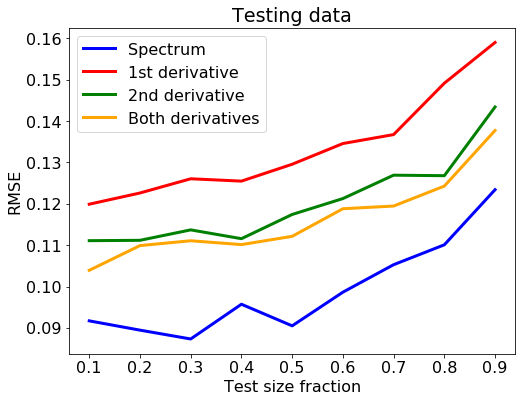

In [45]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=[8,6])
plt.plot(size, rmse_CN_master_list, c='blue', lw=3, label='Spectrum')
plt.plot(size, rmse_CN_master_list_1, c='red', lw=3, label='1st derivative')
plt.plot(size, rmse_CN_master_list_2, c='green', lw=3, label='2nd derivative')
plt.plot(size, rmse_CN_master_list_1_2, c='orange', lw=3, label='Both derivatives')
plt.xlabel('Test size fraction')
plt.ylabel('RMSE')
plt.title('Testing data')
plt.legend()